## Agência Nacional do Cinema - ANCINE

### Desafios e Oportunidades na Indústria Cinematográfica Brasileira

#### **Análise Exploratória de Dados**

Este projeto tem como objetivo realizar uma Análise Exploratória de Dados (EDA) sobre o conjunto de dados abertos ANCINE - Agência Nacional do Cinema. 

Neste estudo, foram explorados os dados referentes aos Agentes Econômicos cadastrados na ANCINE, assim como suas atividades, Investidores,  Obras cinematográficas, Projetos contratados e outros. 


---

## 0. Imports e Carregamento do Projeto

In [12]:
import math

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error as msqerr
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from collections import Counter as co
from matplotlib import pyplot as plt, gridspec
from matplotlib import font_manager as fm
import matplotlib.patches as patches
from wordcloud import WordCloud as wc
from v2_abrir_projeto import Projeto
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

pj = Projeto()
pj.abrir_projeto()


***Bem vindo(a) ao Projeto!***

Para ler documentação: "pj.doc.documentacao"



### 0.1  Exibição da Documentação basilar para navegação.

In [13]:
pj.doc.documentacao()

**** DOCUMENTAÇÃO DO PROJETO ****
***Agência Nacional do Cinema***

Cada Arquivo CSV contém uma variável raíz e um 
número de referência para variáveis específicas.
*
*
Para chamar variável no Jupyter Notebook digite: "df." + variável
*
Para chamar variável específica digite: "df." + "variável_especifica" + número
*
*
Nome arquivo CSV | Nome variável raíz | Número variável específica
-
Agentes Econômicos Regulares = agnts_economicos = 1  
Atividades Economicas dos Agentes Regulares = atividade_economicas_agnts = 2 
Projetos Renúncia Fiscal = proj_renuncia_fiscal = 3  
Obras não Publicitárias Brasileiras - Fomento Indireto = obras_n_publi_fomento_direto =  4 
Obras não Publcitárias Brasileiras - Investimento FSA = obras_n_publi_investimento_fsa =  5 
Processos de Prestação de contas = processos_prestacao_contas = 6  
Investidores de projetos de Renúncia Fiscal = investidores_proj_renuncia_fiscal = 7   
Produtoras Independentes = produtoras_independentes = 8 
Produtores de obra não Publi

### 0.2 Função para carregar variáveis no ambiente local do projeto

In [14]:
#Carregar variáveis no ambiente local (Método para economizar tempo de digitação)
def carregar():
        
        from pandas import DataFrame as pd

        global agnts_economicos
        agnts_economicos = pd(pj.df.agnts_economicos)
        global atividade_economicas_agnts
        atividade_economicas_agnts = pd(pj.df.atividade_economicas_agnts)
        global proj_renuncia_fiscal
        proj_renuncia_fiscal = pd(pj.df.proj_renuncia_fiscal)
        global obras_n_publi_fomento_direto
        obras_n_publi_fomento_direto = pd(pj.df.obras_n_publi_fomento_direto)
        global obras_n_publi_investimento_fsa
        obras_n_publi_investimento_fsa = pd(pj.df.obras_n_publi_investimento_fsa)
        global processos_prestacao_contas
        processos_prestacao_contas = pd(pj.df.processos_prestacao_contas)
        global investidores_proj_renuncia_fiscal
        investidores_proj_renuncia_fiscal = pd(pj.df.investidores_proj_renuncia_fiscal)
        global produtoras_independentes
        produtoras_independentes = pd(pj.df.produtoras_independentes)
        global produtores_obras_n_publi
        produtores_obras_n_publi = pd(pj.df.produtores_obras_n_publi)
        global proj_fsa_desembolso
        proj_fsa_desembolso = pd(pj.df.proj_fsa_desembolso)
        global relacao_grupos_economicos
        relacao_grupos_economicos = pd(pj.df.relacao_grupos_economicos)
        global salas_complexos
        salas_complexos = pd(pj.df.salas_complexos)    
carregar()

---

## 1. Carregamento de dados


*Por conta do modelo de POO que foi aplicado nesse projeto, os dados foram previamente pré-processados, ou seja, não vamos encontrar tabelas com valores nulos ou colunas com tipos de dados equivocados. Para conhecer a documentação desse processo, clique [aqui](https://github.com/fonsecadados/AgenciaNacionalDoCinema_ANCINE/blob/main/processamento_dados.py).*

### 1.2 Unificar Tabelas

Para maior eficiência no código, vamos unificar as tabelas "Agentes Econômicos" e "Atividade dos Agentes Econômicos"

##### 1.2.1 Agentes Econômicos x Atividade dos Agentes Econômicos x Produtores Independentes

In [15]:
def unificar_tabelas_agentes(): #Criando Dataframe merged Agentes Economicos Regulares x Atividades Economicas dos Agentes

    agnts_atividades_economicas = pd.merge(agnts_economicos, atividade_economicas_agnts, on='REGISTRO_ANCINE', how='inner') #Merge tabelas agnt econômicos e atividades
    agnts_atividades_economicas = agnts_atividades_economicas[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL_x', 'CNPJ_x', #selecionando colunas
        'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA', 'ATIVIDADE_ECONOMICA','CLASSIFICACAO_ATIVIDADE', 'BRASILEIRO_INDEPENDENTE']]

    agnts_atividades_economicas.rename(columns={'RAZAO_SOCIAL_x' : 'RAZAO_SOCIAL', 'CNPJ_x' : 'CNPJ'}, inplace=True) #corrigindo nomes das colunas

    agnts_atividades_economicas = agnts_atividades_economicas[agnts_atividades_economicas['CLASSIFICACAO_ATIVIDADE'] == 1] # filtrando a colunaClassificação de atividades para deixar apenas as principais, evitando agentes duplicados

    #Produtoras Independentes
    global produtoras_independentes
    global agnts_tabela_unificada
    global tabela_unificada_atividades_economicas

    produtoras_independentes = produtoras_independentes[['REGISTRO_ANCINE', 'CLASSIFICACAO_NIVEL_PRODUTORA']] # selecionando colunas - Produtoras Independentes
    agnts_tabela_unificada = pd.DataFrame(pd.merge(agnts_atividades_economicas, produtoras_independentes, how='outer', on='REGISTRO_ANCINE')) #Merge tabelas
    agnts_tabela_unificada.dropna(subset='CLASSIFICACAO_NIVEL_PRODUTORA', inplace=True)

    agnts_tabela_unificada = agnts_tabela_unificada.drop_duplicates(subset=['CNPJ'])
unificar_tabelas_agentes()

##### 1.2.3 FSA Desembolso / Renúncia Fiscal x Agentes Econômicos (tabela unificada)

In [16]:
produtoras_proj_renun_fiscal = proj_renuncia_fiscal.copy()
produtoras_proj_renun_fiscal = agnts_tabela_unificada.merge(produtoras_proj_renun_fiscal, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_renun_fiscal = produtoras_proj_renun_fiscal[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'TITULO_PROJETO', 'LEI_8313', 'ART1',
       'ART1A', 'ART3', 'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO',
       'DT_APROVACAO_CAPTACAO', 'DT_1_LIBERACAO']]


produtoras_proj_fsa_desembolso = proj_fsa_desembolso.copy()
produtoras_proj_fsa_desembolso = agnts_tabela_unificada.merge(produtoras_proj_fsa_desembolso, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_fsa_desembolso = produtoras_proj_fsa_desembolso[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'TITULO_PROJETO',
       'CHAMADA_PUBLICA', 'ANO_CHAMADA_PUBLICA', 'DT_PUBLICACAO_CONTRATO_DOU',
       'VL_CONTRATO_DOU', 'DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]


# FSA - DESEMBOLSO
fsa_desembolso = produtoras_proj_fsa_desembolso.copy()
fsa_desembolso['ANO_CHAMADA_PUBLICA'] = fsa_desembolso['ANO_CHAMADA_PUBLICA'].str.split('/').str[-1] 
fsa_desembolso['ANO_CHAMADA_PUBLICA'] = pd.to_numeric(fsa_desembolso['ANO_CHAMADA_PUBLICA'])

data_ficticia = pd.to_datetime('1900-12-31')
fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].fillna(data_ficticia, inplace=True)
fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = pd.to_datetime(fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'])

fsa_desembolso['DT_PUBLICACAO_CONTRATO_DOU'] = pd.to_datetime(fsa_desembolso['DT_PUBLICACAO_CONTRATO_DOU'])

fsa_desembolso['VL_CONTRATO_DOU'] = fsa_desembolso['VL_CONTRATO_DOU'].str.replace(',', '.').astype(float)

fsa_desembolso['VL_TOTAL_LIBERADO'] = fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
fsa_desembolso['VL_TOTAL_LIBERADO'].fillna(0, inplace=True)

fsa_desembolso['CLASSIFICACAO_NIVEL_PRODUTORA'] = fsa_desembolso['CLASSIFICACAO_NIVEL_PRODUTORA'].astype(int)

fsa_desembolso['TITULO_PROJETO'].fillna('Sem Título', inplace=True)

# RENÚNICA FISCAL
renuncia_fiscal = produtoras_proj_renun_fiscal.copy()

renuncia_fiscal['CLASSIFICACAO_NIVEL_PRODUTORA'] = renuncia_fiscal['CLASSIFICACAO_NIVEL_PRODUTORA'].astype(int)

def float_int(coluna):
    zero = '0,0'

    renuncia_fiscal[coluna] = renuncia_fiscal[coluna].str.replace(',', '.').astype(float)

float_int('LEI_8313')
float_int('ART1')
float_int('ART1A')
float_int('ART3')
float_int('ART3A')
float_int('ART39')
float_int('FUNCINES')
float_int('TOTAL_CAPTADO')

### 1.3 Visualizar Tabela

In [17]:
#Função que retorne o perfil de um banco de dados
def perfil_banco_dados(df):
    duplicado = df['CNPJ'].duplicated()
    soma_duplicado = duplicado.sum()
    
    print('Raio-x')
    print()
    print(df.info())
    print('----')
    
    if soma_duplicado > 0:
        print(f'A coluna CNPJ possui {soma_duplicado} valores duplicados.')
    else:
        print('A coluna CNPJ não possui valores duplicados.')
    
    print('----')
    return df.sample(5)

##### 1.3.2 Agentes (tabela unificada)

In [18]:
perfil_banco_dados(agnts_tabela_unificada)

Raio-x

<class 'pandas.core.frame.DataFrame'>
Index: 11354 entries, 0 to 18571
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                11354 non-null  int64         
 1   DATA_REGISTRO                  11354 non-null  datetime64[ns]
 2   RAZAO_SOCIAL                   11354 non-null  object        
 3   CNPJ                           11354 non-null  object        
 4   DATA_CONSTITUICAO              11354 non-null  datetime64[ns]
 5   UF                             11354 non-null  object        
 6   MUNICIPIO                      11354 non-null  object        
 7   NATUREZA_JURIDICA              11354 non-null  object        
 8   ATIVIDADE_ECONOMICA            11354 non-null  object        
 9   CLASSIFICACAO_ATIVIDADE        11354 non-null  int64         
 10  BRASILEIRO_INDEPENDENTE        11354 non-null  bool          
 11  CLASSIFICACA

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_ATIVIDADE,BRASILEIRO_INDEPENDENTE,CLASSIFICACAO_NIVEL_PRODUTORA
4074,25336,2013-10-04,ANNITA FILMES LTDA,18.162.430/0001-75,2013-04-25,RS,SÃO BORJA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0
2000,14944,2009-02-04,OUTROS FILMES PRODUÇÕES ARTÍSTICAS E CINEMATOG...,10.347.990/0001-92,2008-08-05,SP,SÃO PAULO,Empresa Individual de Responsabilidade Limitad...,"Atividades de produção cinematográfica, de víd...",1,True,2.0
10471,45758,2020-05-22,MARCUS VINICIUS DE MATOS SA E SERVICOS DE FILM...,35.972.433/0001-93,2020-01-12,CE,FORTALEZA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0
14697,52061,2022-09-15,BLANCO EDITORA E AUDIOVISUAL LTDA,22.746.047/0001-31,2015-06-29,PR,LONDRINA,Sociedade Empresária Limitada,"Edição de cadastros, listas e outros produtos ...",1,True,1.0
17330,55650,2023-10-17,CURIMA FILMES E PRODUÇÕES LTDA,34.078.328/0001-42,2019-07-01,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0


##### 1.3.3 FSA - Desembolso

In [19]:
perfil_banco_dados(fsa_desembolso)

Raio-x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                3353 non-null   int64         
 1   DATA_REGISTRO                  3353 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   3353 non-null   object        
 3   CNPJ                           3353 non-null   object        
 4   DATA_CONSTITUICAO              3353 non-null   datetime64[ns]
 5   UF                             3353 non-null   object        
 6   MUNICIPIO                      3353 non-null   object        
 7   NATUREZA_JURIDICA              3353 non-null   object        
 8   ATIVIDADE_ECONOMICA            3353 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  3353 non-null   int32         
 10  TITULO_PROJETO                 3353 non-null   object        
 11  CHAMADA_P

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,TITULO_PROJETO,CHAMADA_PUBLICA,ANO_CHAMADA_PUBLICA,DT_PUBLICACAO_CONTRATO_DOU,VL_CONTRATO_DOU,DT_PRIMEIRO_DESEMBOLSO,VL_TOTAL_LIBERADO
898,1591,2004-02-26,LUZ PRODUÇÕES CINEMATOGRÁFICAS LTDA.,00.975.333/0001-36,1995-11-28,CE,FORTALEZA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,BATE CORAÇÃO,PRODECINE 04,2013,2018-01-10,492968.0,2018-01-18,492968.0
3265,34020,2016-08-29,MONTANHA RUSSA CINEMATOGRÁFICA LTDA ME,25.263.548/0001-55,2016-07-21,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",2,AMORES CUBANOS,PRODAV 01,2013,2017-11-01,850168.0,2017-11-09,850168.0
2785,24258,2013-05-31,SOL A PINO FILMES LTDA,17.942.221/0001-81,2013-04-16,GO,GOIÂNIA,Sociedade Empresária Limitada,Estúdios cinematográficos,1,PANACEIA NÚCLEO CRIATIVO,PRODAV 03,2015,2016-11-22,902400.0,2016-12-13,902400.0
69,87,2004-02-26,PRODIGO FILMS LTDA,00.020.648/0001-20,1994-06-21,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,ESTAÇÃO LIBERDADE,PRODECINE 01,2008,2010-08-25,500000.0,2011-01-06,500000.0
1306,4745,2005-09-15,PONTO DAS ARTES DE ANCHIETA LTDA.,00.793.584/0001-08,1995-07-25,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,Atividades de exibição cinematográfica,1,POLO AUDIOVISUAL PONTO CINE,SAV/MINC 13,2018,2019-10-02,400000.0,2019-10-11,400000.0


##### 1.3.4 Renúncia Fiscal

In [20]:
perfil_banco_dados(renuncia_fiscal)

Raio-x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                2609 non-null   int64         
 1   DATA_REGISTRO                  2609 non-null   datetime64[ns]
 2   RAZAO_SOCIAL                   2609 non-null   object        
 3   CNPJ                           2609 non-null   object        
 4   DATA_CONSTITUICAO              2609 non-null   datetime64[ns]
 5   UF                             2609 non-null   object        
 6   MUNICIPIO                      2609 non-null   object        
 7   NATUREZA_JURIDICA              2609 non-null   object        
 8   ATIVIDADE_ECONOMICA            2609 non-null   object        
 9   CLASSIFICACAO_NIVEL_PRODUTORA  2609 non-null   int32         
 10  TITULO_PROJETO                 2609 non-null   object        
 11  LEI_8313 

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_NIVEL_PRODUTORA,...,LEI_8313,ART1,ART1A,ART3,ART3A,ART39,FUNCINES,TOTAL_CAPTADO,DT_APROVACAO_CAPTACAO,DT_1_LIBERACAO
2499,27416,2014-08-06,MOOD HUNTER PRODUÇÕES LTDA,06.177.126/0001-12,2004-03-24,SP,SÃO PAULO,Sociedade Empresária Limitada,Estúdios cinematográficos,2,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,2021-07-12,2022-05-06
160,87,2004-02-26,PRODIGO FILMS LTDA,00.020.648/0001-20,1994-06-21,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",5,...,0.0,0.0,0.0,0.00,0.0,1652750.15,0.0,1652750.15,2017-05-30,2017-10-24
500,351,2004-03-31,A.F. CINEMA E VÍDEO LTDA,69.126.670/0001-55,1993-04-01,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",4,...,0.0,0.0,550000.0,0.00,0.0,0.00,0.0,550000.00,2013-10-07,2015-11-26
83,35,2002-05-31,MOVI & ART PRODUCOES CINEMATOGRAFICAS EIRELI,46.397.220/0001-00,1974-01-26,SP,SÃO PAULO,Empresa Individual de Responsabilidade Limitad...,"Atividades de produção cinematográfica, de víd...",3,...,0.0,0.0,0.0,3326499.34,0.0,0.00,0.0,3326499.34,2014-11-26,2018-11-13
1615,2937,2004-12-22,DESIGN E IMAGEM COMUNICAÇÃO EMPRESARIAL LTDA,86.628.492/0001-80,1994-09-26,RJ,CABO FRIO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",1,...,0.0,0.0,1000000.0,0.00,0.0,0.00,0.0,1000000.00,2014-02-19,2015-12-11


### 1.4 Dimensões e NA

In [21]:
def dimensao_na(df, df_name=None):

    unique_values = df.apply(lambda x: x.nunique())
    null_values = df.isnull().sum()

    nome_df = pd.DataFrame({
        'Quantidade de Valores' : unique_values.values,
        'Tipo da Coluna' : df.dtypes,
        'Quantidade de Nulos' : null_values.values   
    }).reset_index()

    print(f"DataFrame name: {df_name}")
    return nome_df

##### 1.4.2 Agentes (tabela unificada)

In [22]:
dimensao_na(agnts_tabela_unificada, "Agentes Econômicos - Tabela Unificada")

DataFrame name: Agentes Econômicos - Tabela Unificada


,index,Quantidade de Valores,Tipo da Coluna,Quantidade de Nulos
0,REGISTRO_ANCINE,11354,int64,0
1,DATA_REGISTRO,3838,datetime64[ns],0
2,RAZAO_SOCIAL,11343,object,0
3,CNPJ,11354,object,0
4,DATA_CONSTITUICAO,5651,datetime64[ns],0
5,UF,27,object,0
6,MUNICIPIO,681,object,0
7,NATUREZA_JURIDICA,10,object,0
8,ATIVIDADE_ECONOMICA,186,object,0
9,CLASSIFICACAO_ATIVIDADE,1,int64,0


##### 1.4.3 FSA Desembolso

In [23]:
dimensao_na(fsa_desembolso, "FSA- Desembolso")

DataFrame name: FSA- Desembolso


,index,Quantidade de Valores,Tipo da Coluna,Quantidade de Nulos
0,REGISTRO_ANCINE,1122,int64,0
1,DATA_REGISTRO,939,datetime64[ns],0
2,RAZAO_SOCIAL,1122,object,0
3,CNPJ,1122,object,0
4,DATA_CONSTITUICAO,1037,datetime64[ns],0
5,UF,27,object,0
6,MUNICIPIO,109,object,0
7,NATUREZA_JURIDICA,8,object,0
8,ATIVIDADE_ECONOMICA,38,object,0
9,CLASSIFICACAO_NIVEL_PRODUTORA,5,int32,0


##### 1.4.4 Renúncia Fiscal

In [24]:
dimensao_na(renuncia_fiscal, "Renúncia Fiscal")

DataFrame name: Renúncia Fiscal


,index,Quantidade de Valores,Tipo da Coluna,Quantidade de Nulos
0,REGISTRO_ANCINE,755,int64,0
1,DATA_REGISTRO,629,datetime64[ns],0
2,RAZAO_SOCIAL,755,object,0
3,CNPJ,755,object,0
4,DATA_CONSTITUICAO,726,datetime64[ns],0
5,UF,19,object,0
6,MUNICIPIO,59,object,0
7,NATUREZA_JURIDICA,8,object,0
8,ATIVIDADE_ECONOMICA,21,object,0
9,CLASSIFICACAO_NIVEL_PRODUTORA,5,int32,0


---

## 2. Análise Exploratória

#### Atividades Econômicas dos Agentes

##### 2.1 Sumário e Nuvem de Palavras

In [25]:
#Além de dados estatísticos sobre as atividades econômicas, vamos extrair nuvens de palavras encontradas nas 
#atividades mais recorrentes e menos recorrentes das produtoras com classificação de nível.

#Criar lista de atividades econômicas
lista_atividades = agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].tolist()

palavra = []
for atividade in lista_atividades:
    palavra.extend(atividade.split())

#Excluir outliers 
lista_atividades_counter = co(lista_atividades)
palavra_counter = co(palavra) #Método para contar as palavras
print(f'Número de Atividades Econômicas distintas: {len(lista_atividades_counter)}')

atividade_economica_contagem = pd.DataFrame(agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].value_counts().head(10))
atividade_economica_contagem

Número de Atividades Econômicas distintas: 186


,count
ATIVIDADE_ECONOMICA,
"Atividades de produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",5488
Produção de filmes para publicidade,1337
Estúdios cinematográficos,676
"Artes cênicas, espetáculos e atividades complementares não especificados anteriormente",462
Agências de publicidade,364
"Atividades de pós-produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",363
"Serviços de organização de feiras, congressos, exposições e festas",227
"Atividades de produção de fotografias, exceto aérea e submarina",199
Produção teatral,194


Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas


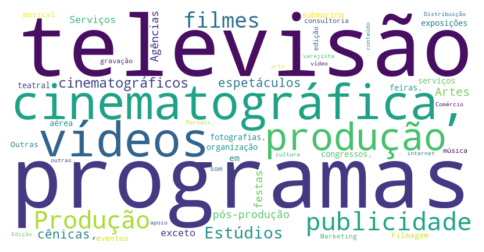

Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas


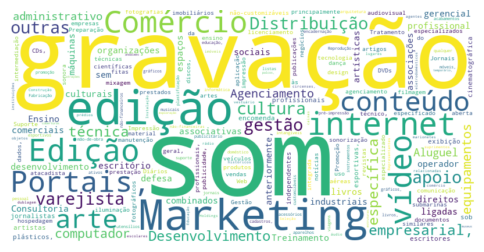

In [26]:
#Lista de palavras da tabela de produtoras independentes para excluir
palavras_excluir = ['de', 'e', 'não', 'anteriormente', 'Atividades', 'especificadas', 'para', 'atividades',\
                     'especificados', 'complementares', 'à', 'na', 'direto', 'outros', 'informação', 'provedores']
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]
# palavras_frequencia = co(palavras_frequencia)
# Suponha que você tenha a lista de palavras filtradas armazenada em 'palavras_frequencia'
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]

# Crie um objeto Counter com as palavras filtradas
contador_palavras = co(palavras_frequencia)

# Obtenha as 25 palavras mais comuns
maior_frequencia = contador_palavras.most_common(50)
menor_frequencia = contador_palavras.most_common()[-399:]

# Converta as palavras e suas frequências em um dicionário
dic_palavras_maior_frequencia = dict(maior_frequencia)
dic_palavras_menor_frequencia = dict(menor_frequencia)

# Crie uma nuvem de palavras para as 25 palavras mais comuns
nuvem_palavras_maior_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_maior_frequencia)

# Plote a nuvem de palavras para as 25 palavras mais comuns
print('Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_maior_frequencia, interpolation='bilinear')
plt.axis('off')
plt.show()

# Crie uma nuvem de palavras para as 415 palavras menos comuns
nuvem_palavras_menor_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_menor_frequencia)

# Plote a nuvem de palavras para as 415 palavras menos comuns
print('Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_menor_frequencia, interpolation='bilinear')
plt.axis('off')
plt.show()

---

##### 2.2 Distribuição dos Agentes Econômicos no País (Produtores Independentes)

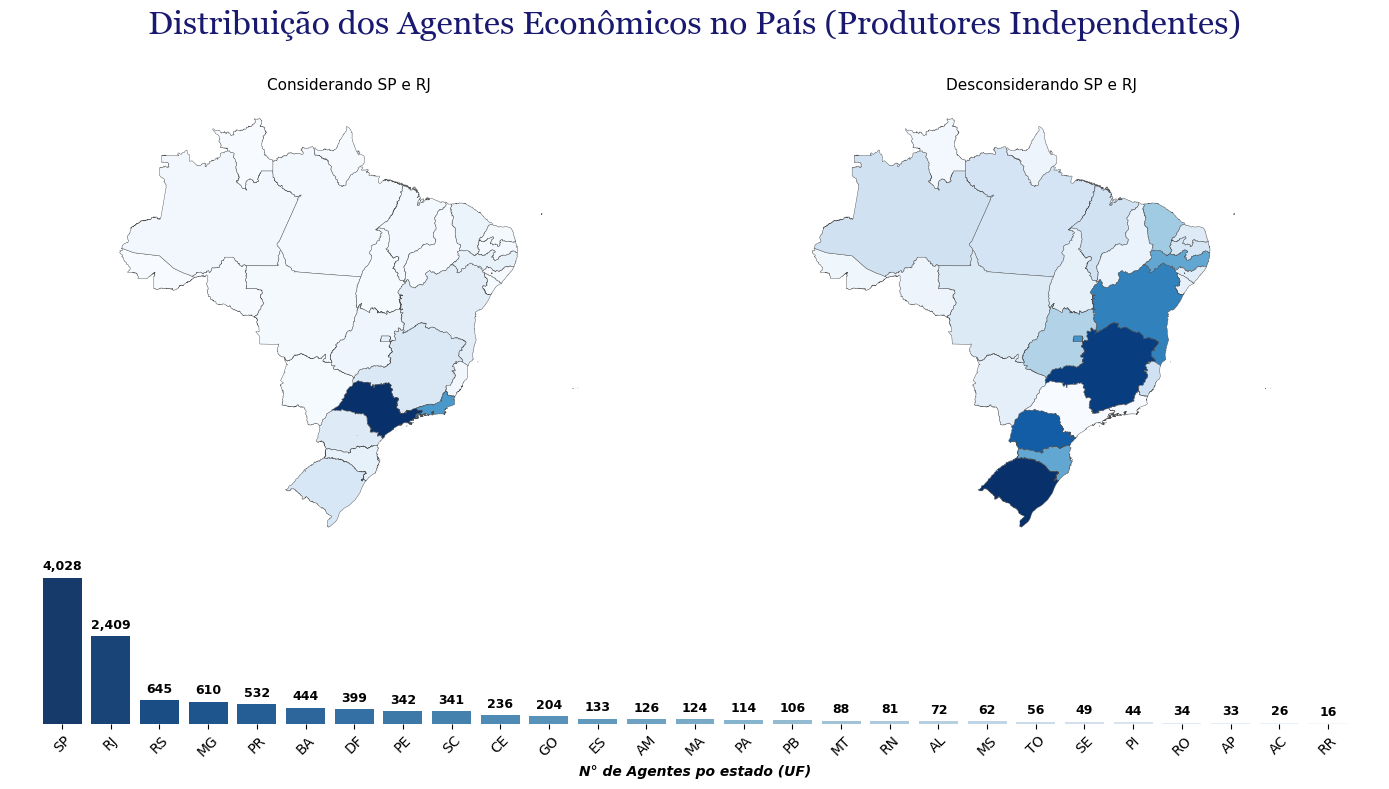

In [27]:
# Carregar mapa BR
brasil = gpd.read_file('C:\\Users\\syafo\\OneDrive\\Documentos\\GitHub\\AgenciaNacionalDoCinema_ANCINE\\geopandas\\BR_UF_2022.shp')

# Plot com todos os estados
totais_por_estado = agnts_tabela_unificada['UF'].value_counts().reset_index()
totais_por_estado.columns = ['UF', 'Total']

brasil = brasil.merge(totais_por_estado, left_on='SIGLA_UF', right_on='UF')

# Filtrar os dados excluindo SP e RJ
estados_sem_sp_rj = agnts_tabela_unificada[(agnts_tabela_unificada['UF'] != 'RJ') & (agnts_tabela_unificada['UF'] != 'SP')]
estados_count = estados_sem_sp_rj['UF'].value_counts().reset_index()
estados_count.columns = ['UF', 'Total']

# Adicionar linhas para SP e RJ com total zero
sp_row = pd.DataFrame({'UF': ['SP'], 'Total': [0]})
rj_row = pd.DataFrame({'UF': ['RJ'], 'Total': [0]})
estados_count = pd.concat([estados_count, sp_row, rj_row], ignore_index=True)

estados_count = estados_count.sort_values(by='UF')
estados_count = estados_count.rename(columns={'UF': 'UF_count', 'Total': 'Total_count'})
brasil_estados = brasil.merge(estados_count, left_on='SIGLA_UF', right_on='UF_count')

# Criar a figura
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[2, 2])
# Plotar mapa dos estados sem SP e RJ
ax1 = plt.subplot(gs[0,0])
brasil_estados.plot(column='Total', cmap='Blues', linewidth=0.3, ax=ax1, edgecolor='0.3', legend=False)
ax1.set_title('Considerando SP e RJ', fontsize=11, fontweight='light')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Plotar mapa dos estados com SP e RJ
ax2 = plt.subplot(gs[0,1])
brasil_estados.plot(column='Total_count', cmap='Blues', linewidth=0.3, ax=ax2, edgecolor='0.3', legend=False)
ax2.set_title('Desconsiderando SP e RJ', fontsize=11, fontweight='light')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Plotar gráfico de barras
ax3 = plt.subplot(gs[1, :])
sns.countplot(data=agnts_tabela_unificada, x='UF', order=agnts_tabela_unificada['UF'].value_counts().index, palette='Blues_r', ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 8), 
                   textcoords='offset points',
                   fontsize=9, fontweight='bold')
# ax3.set_title('Quantidade de Agentes Econômicos por Estado', fontsize=13, fontweight='medium')
ax3.set_xlabel('N° de Agentes po estado (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax3.set_ylabel(None)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=10, fontweight='normal') 
ax3.set_yticks([])
ax3.margins(0.025)
plt.tight_layout()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}

plt.suptitle('Distribuição dos Agentes Econômicos no País (Produtores Independentes)', fontdict=fontprops, fontsize=24)
plt.subplots_adjust(top=0.87)
plt.show()


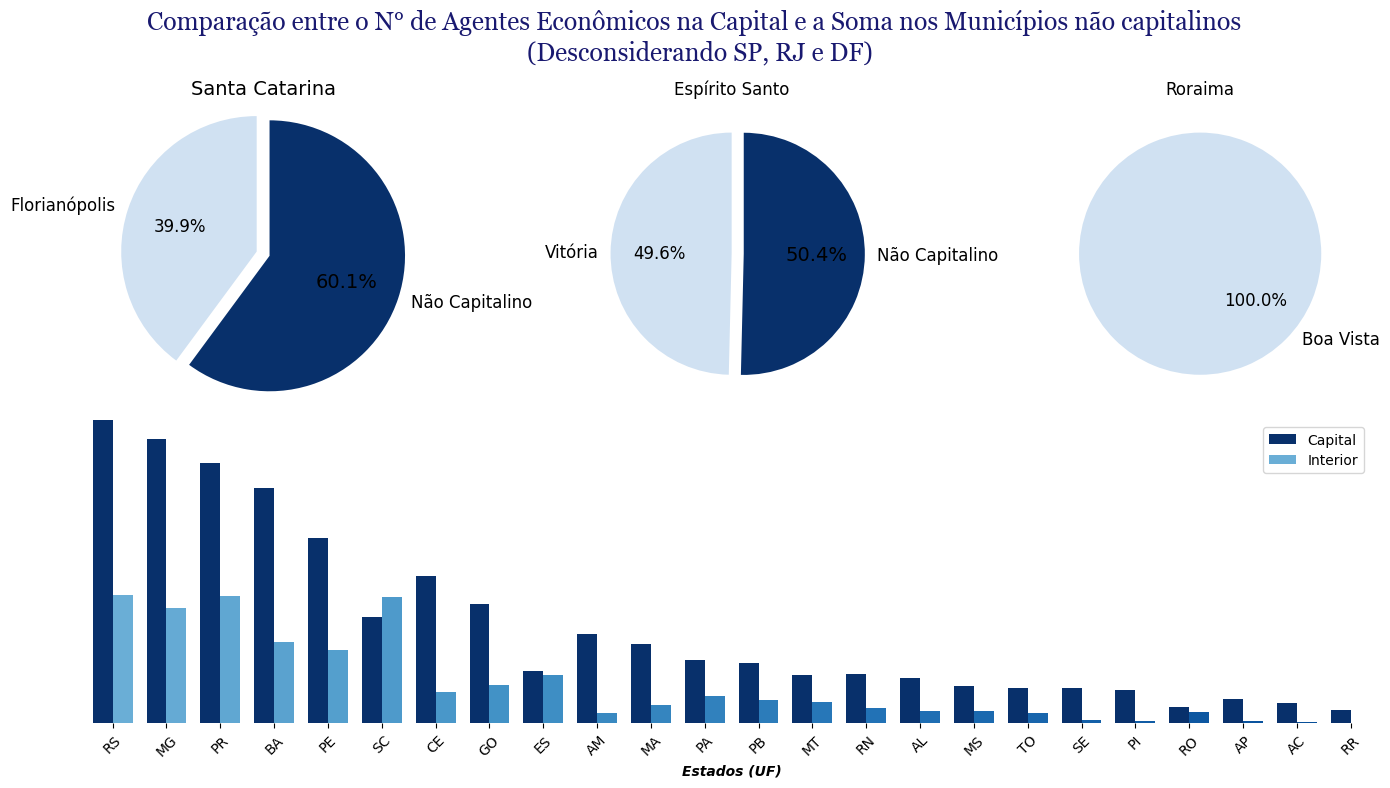

In [28]:
#Gráficos de Pizza
santa_catarina = agnts_tabela_unificada.query("UF == 'SC'")['MUNICIPIO'].value_counts()
roraima = agnts_tabela_unificada.query("UF == 'RR'")['MUNICIPIO'].value_counts()
espirito_santo = agnts_tabela_unificada.query("UF == 'ES'")['MUNICIPIO'].value_counts()

santa_catarina_interior = santa_catarina.sum() - santa_catarina.iloc[0]
roraima_interior = roraima.sum() - roraima.iloc[0]
espirito_santo_interior = espirito_santo.sum() - espirito_santo.iloc[0]

santa_catarina_pie = {'Florianópolis': 136,
                        'Não Capitalino' : 205}

roraima_pie = {'Boa Vista': 16}

espirito_santo_pie = {'Vitória' : 66,
                      'Não Capitalino' : 67}

cores_sc = plt.cm.Blues(np.linspace(0.2, 1, len(santa_catarina_pie)))
cores_es = plt.cm.Blues(np.linspace(0.2, 1, len(roraima_pie)))
cores_rr = plt.cm.Blues(np.linspace(0.2, 1, len(espirito_santo_pie)))

####

#Gráfico de Barras
#Função para comparar o número de Agentes Econômicos nas capitais e no interior dos UFs
def capital_vs_interior(uf, produtora_classificacao):
    separar_uf = produtora_classificacao[produtora_classificacao['UF'] == uf]
    capital = separar_uf['MUNICIPIO'].value_counts().head(1)
    interior = separar_uf['MUNICIPIO'].value_counts().head(15).sum() - capital 
    nome_capital = capital.index[0]
    capital.rename(index={nome_capital : 'Capital'}, inplace=True)
    interior.rename(index={nome_capital : 'Interior'}, inplace=True)
    return capital, interior

estados = [ 'RS', 'MG', 'PR', 'BA', 'PE', 'SC', 
           'CE', 'GO', 'ES', 'AM', 'MA', 'PA', 'PB', 'MT', 
           'RN', 'AL', 'MS', 'TO', 'SE', 'PI', 'RO', 'AP', 'AC', 'RR'] #Lista de UFs

capitais = []
interiores = [] #lista para armazenar os valores

for uf in estados: #Loop for sobre cada estado
    capital, interior = capital_vs_interior(uf, agnts_tabela_unificada)
    capitais.append(capital)
    interiores.append(interior)


#####
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 3], width_ratios=[3, 3, 3])


##########################################

# Pie - Santa Catarina
ax1 = plt.subplot(gs[0, 0])
wedges, texts, autotexts = ax1.pie(santa_catarina_pie.values(), labels=santa_catarina_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax1.set_title('Santa Catarina', fontsize=14, fontweight='medium')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

#Pie - Espírito Santo
ax2 = plt.subplot(gs[0, 1])
wedges, texts, autotexts = ax2.pie(espirito_santo_pie.values(), labels=espirito_santo_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax2.set_title('Espírito Santo', fontsize=12, fontweight='medium')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#Pie - Roraima
ax3 = plt.subplot(gs[0,2])
ax3.pie(roraima_pie.values(), labels=roraima_pie.keys(),colors=cores_rr,  
           autopct='%1.1f%%', startangle=140, shadow=False, textprops={'fontsize': 12, 'fontweight': 'medium'})
ax3.set_title('Roraima', fontsize=12, fontweight='medium')
ax3.set_xlabel(None)
ax3.set_ylabel(None)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


#############
#Criação do Plot com 3 gráficos 
#Gráfico de barras       
bar_width = 0.37 #largura das barras
r1 = np.arange(len(estados)) #posição das barras
r2 = [x + bar_width for x in r1] #posição das barras
cores_int = plt.cm.Blues(np.linspace(0.5, 0.9, len(estados))) #definindo cores
cores_cap = plt.cm.Blues(np.linspace(1, 2, len(estados))) #definindo cores

ax4 = plt.subplot(gs[1, :])
# Plot das capitais
ax4 = plt.bar(r1, [c.values[0] for c in capitais], color=cores_cap, width=bar_width, label='Capital')

# Plot dos interiores
ax4 = plt.bar(r2, [i.values[0] for i in interiores], color=cores_int, width=bar_width, label='Interior')

ax4 = plt.xlabel('Estados (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax4 = plt.ylabel(None)
ax4 = plt.xticks([r + bar_width/2 for r in range(len(estados))], estados)  # Definindo os rótulos do eixo x como os estados
ax4 = plt.legend()
ax4 = plt.xticks(rotation=45, fontweight='medium')
ax4 = plt.yticks([])
ax4 = plt.margins(False)
ax4 = plt.box([])


fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Comparação entre o N° de Agentes Econômicos na Capital e a Soma nos Municípios não capitalinos \n (Desconsiderando SP, RJ e DF)', fontdict=fontprops, fontsize=18)
plt.subplots_adjust(top=0.87)
plt.tight_layout()
plt.show()


##### 2.3 Naturezas Jurídicas

In [29]:
#Naturezas Jurídicas
consultas = {
    'ltda': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Empresária Limitada'"),
    'mei': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresário (Individual)'"),
    'eireli_empresaria': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)'"),
    'ss_limitada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Simples Limitada'"),
    'associacao_privada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Associação Privada'"),
    'eireli_simples': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)'"),
    'sa_fechada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Anônima Fechada'")
}

globals().update(consultas)

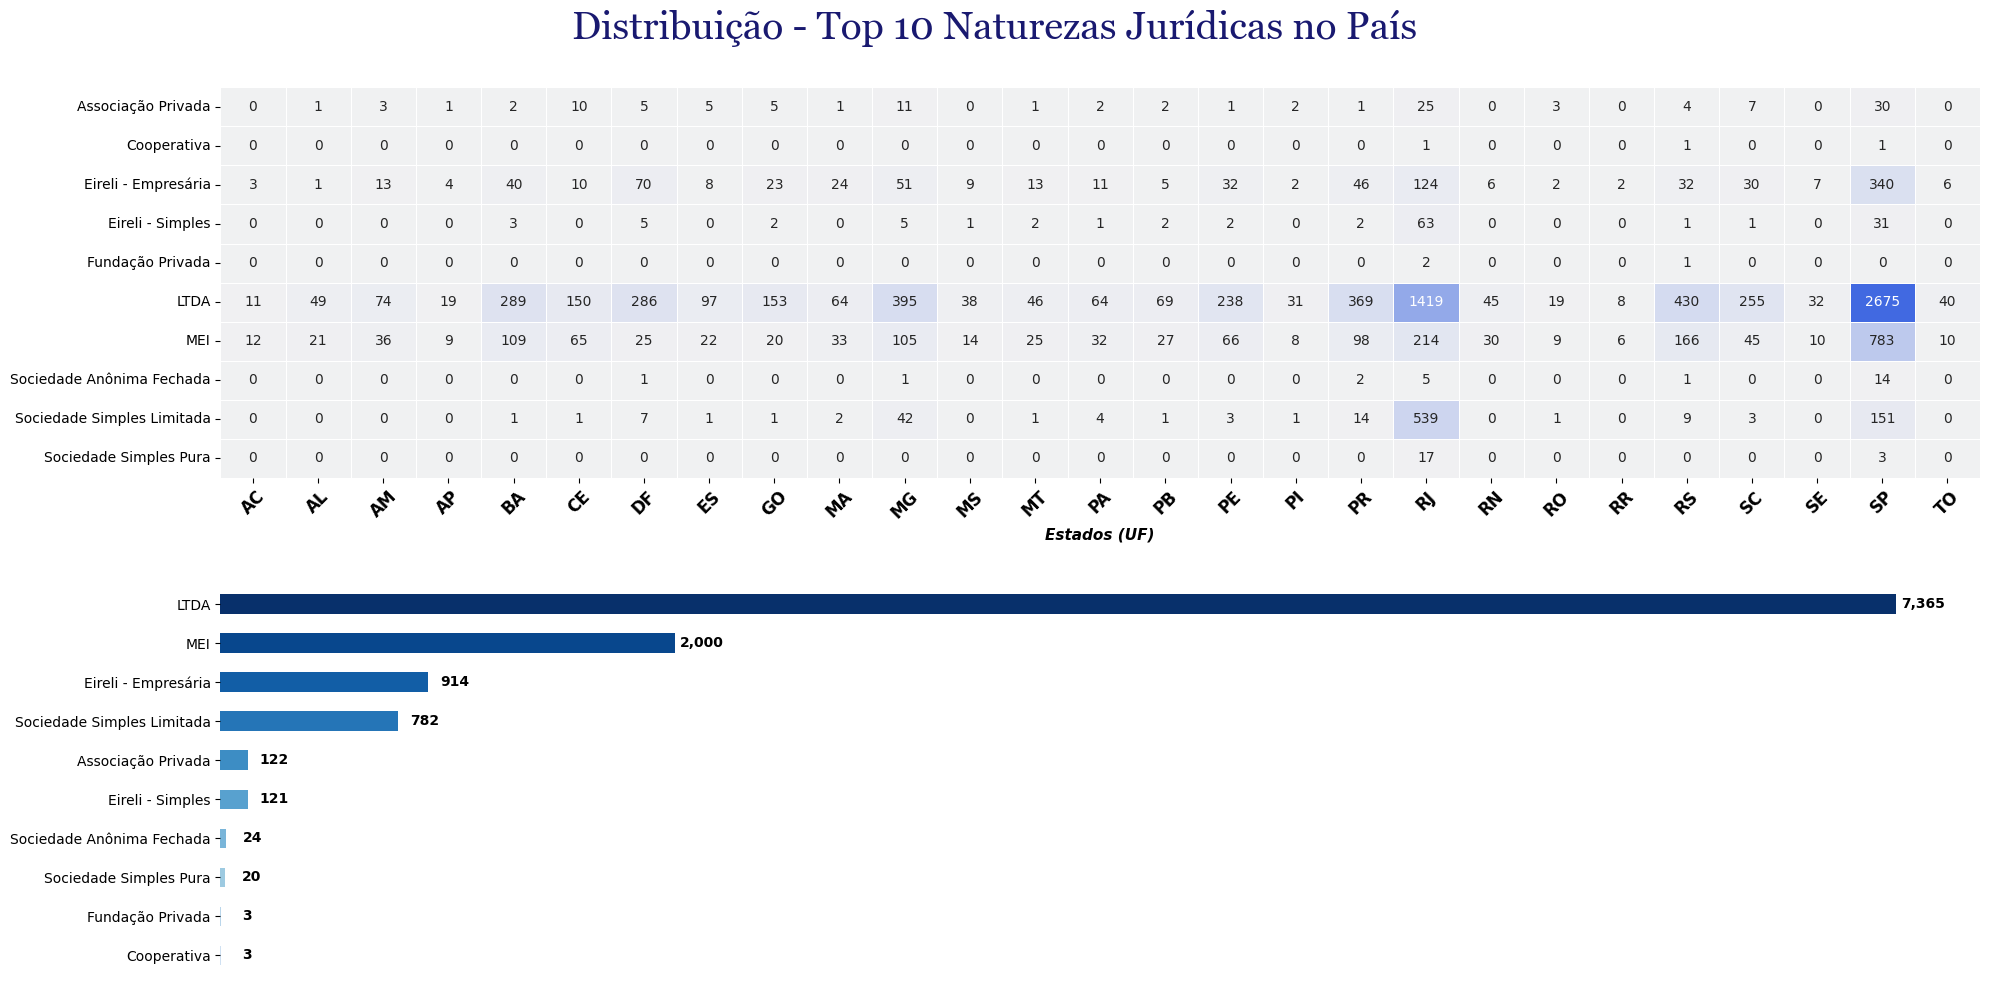

In [30]:
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1)
axs = [plt.subplot(gs[i]) for i in range(2)]


natureza_juridica = pd.DataFrame(agnts_tabela_unificada)
natureza_juridica['NATUREZA_JURIDICA'] = natureza_juridica['NATUREZA_JURIDICA'].replace({
    'Sociedade Empresária Limitada': 'LTDA',
    'Empresário (Individual)': 'MEI',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)': 'Eireli - Empresária',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)': 'Eireli - Simples'
})
ranking_natureza_juridica_top_10 = natureza_juridica['NATUREZA_JURIDICA'].value_counts().head(10)

cores = plt.cm.Blues(np.linspace(0.2, 1, len(ranking_natureza_juridica_top_10)))
ranking_natureza_juridica_top_10.sort_values(ascending=True).plot(kind='barh', color=cores, ax=axs[1])

for n in axs[1].patches:
    axs[1].annotate(format(n.get_width(), ',.0f'),
                    (n.get_width(), n.get_y() + n.get_height() / 2.),
                    ha='center', va='center',
                    xytext=(19, 0),
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

axs[1].set_title('   ', fontsize=17, fontweight='medium')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontweight='medium')
axs[1].set_xticks([])
# axs[0].box(False)
# axs[0].set_yticks(fontweight='bold')
# axs[0].tight_layout()


pivot_table = pd.crosstab(natureza_juridica['NATUREZA_JURIDICA'], natureza_juridica['UF'])
cor = sns.color_palette("light:royalblue", as_cmap=True)
axs[0] = sns.heatmap(pivot_table, annot=True, fmt='d', linewidths=0.5, cmap=cor, ax=axs[0], cbar=False)
axs[0].set_xlabel('Estados (UF)', fontweight='bold', fontsize=11, fontstyle='oblique')
axs[0].set_ylabel(None)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontweight='medium', rotation=0)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontweight='bold', fontsize=12, rotation=45)
axs[0].set_title("   ", fontsize=20)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Distribuição - Top 10 Naturezas Jurídicas no País', fontdict=fontprops, fontsize=28)
plt.subplots_adjust(top=1.87)
plt.subplots_adjust(hspace=1.5)
# plt.suptitle('Quantidade de Agentes por natureza jurídica', fontsize=14)
plt.box([])
plt.tight_layout()
plt.show()


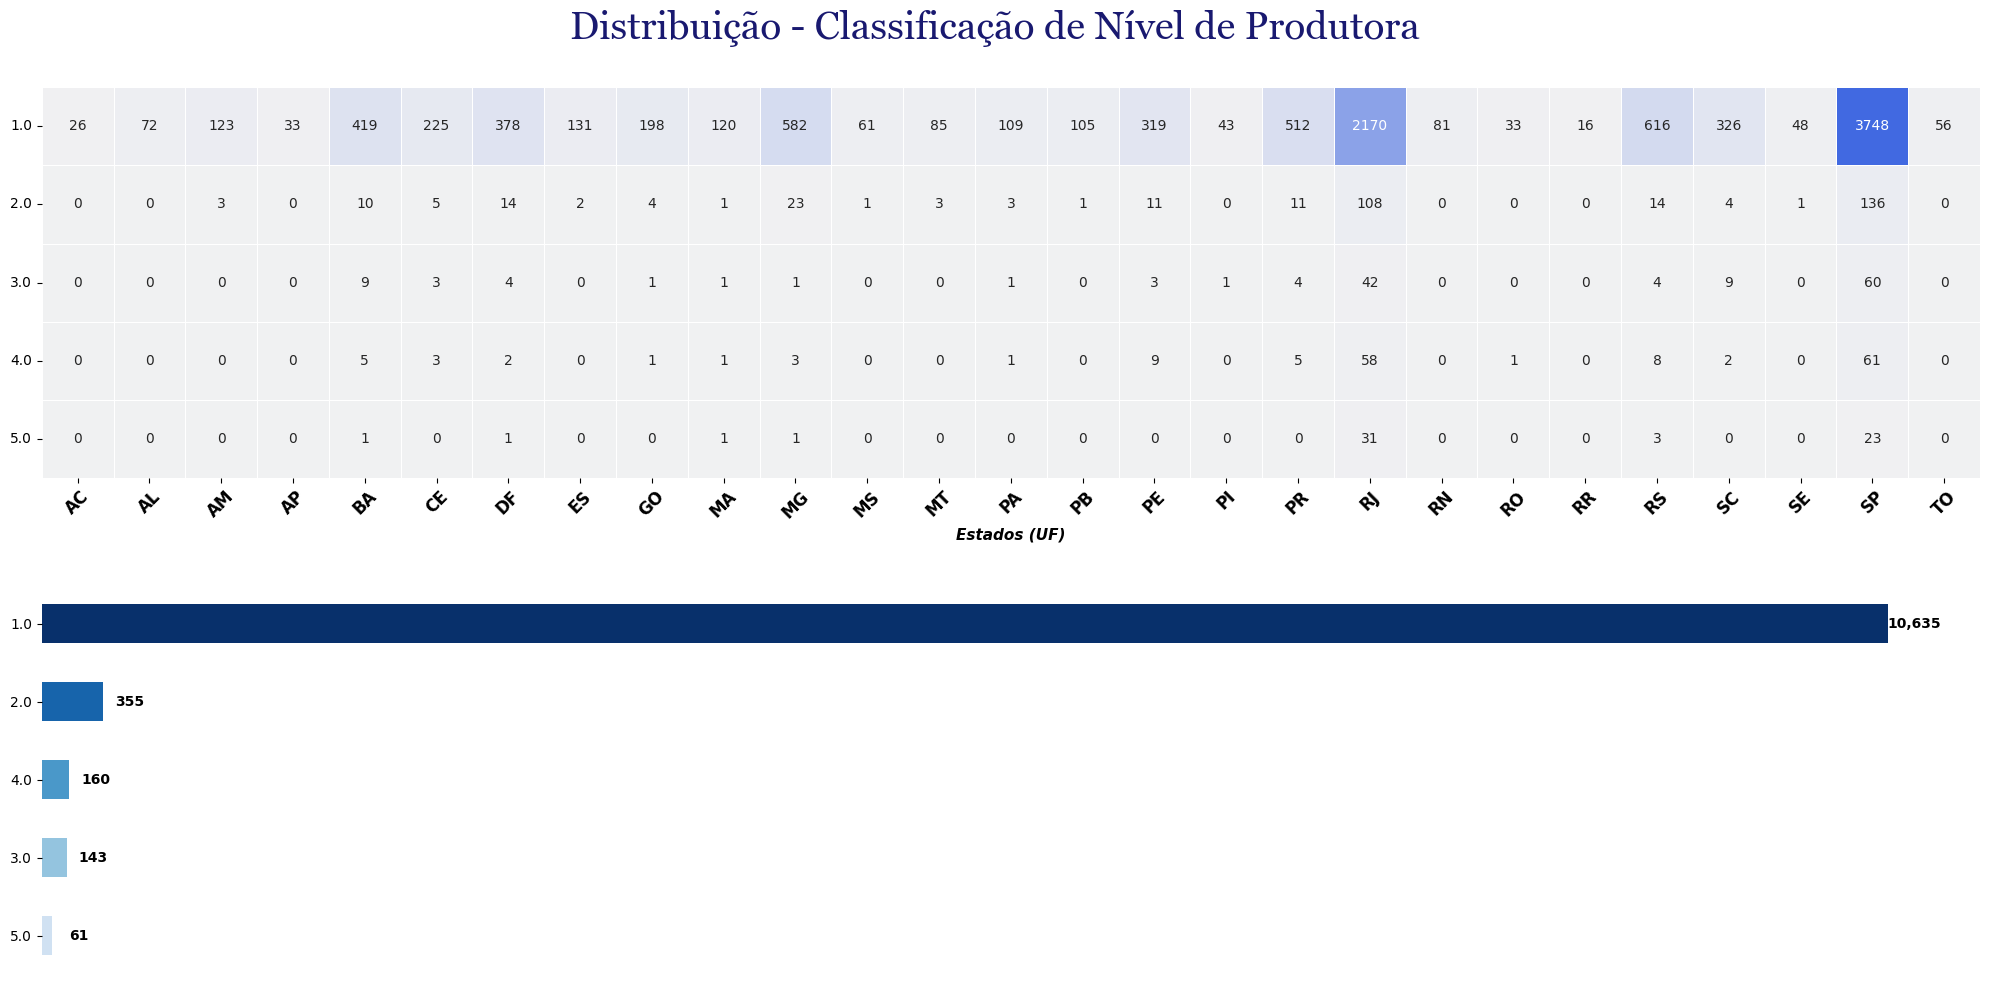

In [31]:
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1)
axs = [plt.subplot(gs[i]) for i in range(2)]


tabela_classificacao_produtora = pd.DataFrame(agnts_tabela_unificada[['UF', 'CLASSIFICACAO_NIVEL_PRODUTORA']])

tabela_classificacao_produtora_top = tabela_classificacao_produtora['CLASSIFICACAO_NIVEL_PRODUTORA'].value_counts().head(5)

cores = plt.cm.Blues(np.linspace(0.2, 1, len(tabela_classificacao_produtora_top)))
tabela_classificacao_produtora_top.sort_values(ascending=True).plot(kind='barh', color=cores, ax=axs[1])

for n in axs[1].patches:
    axs[1].annotate(format(n.get_width(), ',.0f'),
                    (n.get_width(), n.get_y() + n.get_height() / 2.),
                    ha='center', va='center',
                    xytext=(19, 0),
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

axs[1].set_title('   ', fontsize=17, fontweight='medium')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontweight='medium')
axs[1].set_xticks([])


pivot_table = pd.crosstab(tabela_classificacao_produtora['CLASSIFICACAO_NIVEL_PRODUTORA'], tabela_classificacao_produtora['UF'])
cor = sns.color_palette("light:royalblue", as_cmap=True)
axs[0] = sns.heatmap(pivot_table, annot=True, fmt='d', linewidths=0.5, cmap=cor, ax=axs[0], cbar=False)
axs[0].set_xlabel('Estados (UF)', fontweight='bold', fontsize=11, fontstyle='oblique')
axs[0].set_ylabel(None)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontweight='medium', rotation=0)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontweight='bold', fontsize=12, rotation=45)
axs[0].set_title("   ", fontsize=20)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Distribuição - Classificação de Nível de Produtora', fontdict=fontprops, fontsize=28)
plt.subplots_adjust(top=1.87)
plt.subplots_adjust(hspace=1.5)

plt.box([])
plt.tight_layout()
plt.show()


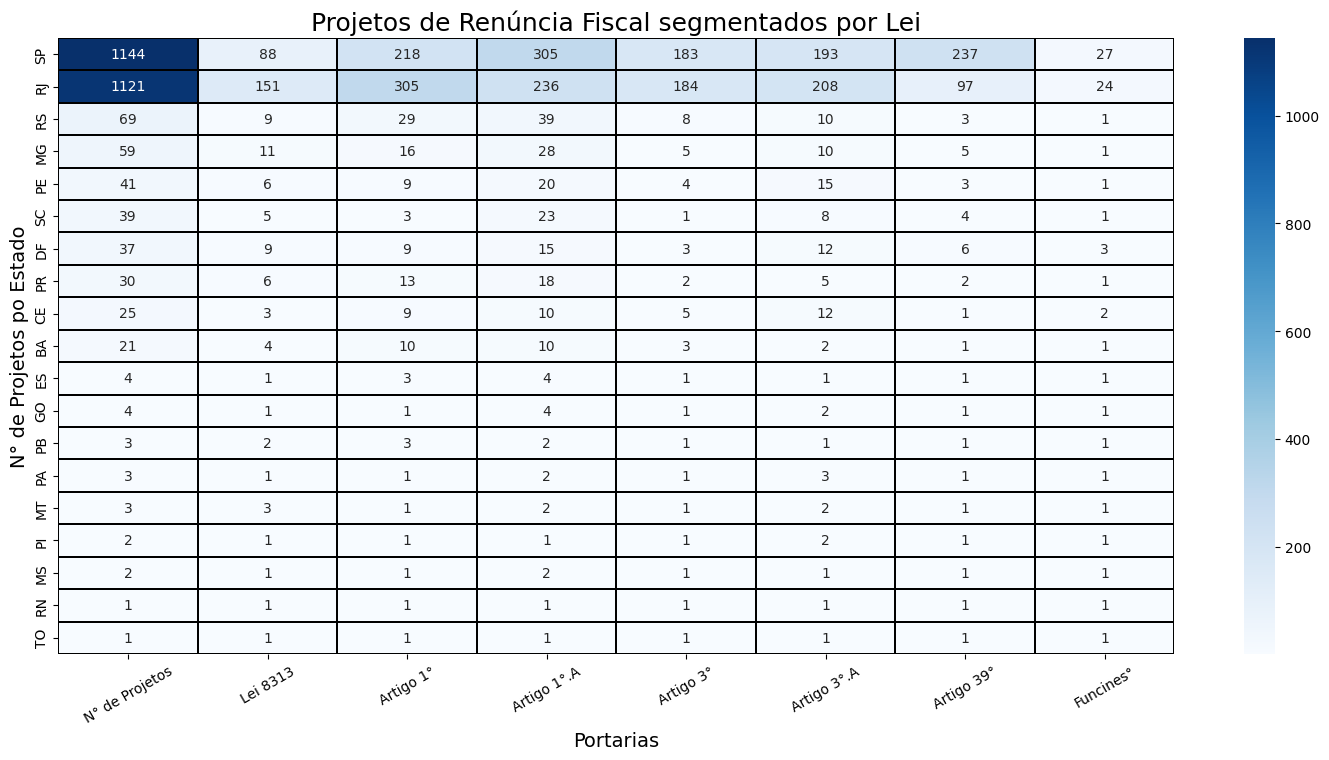

In [32]:
# df_teste_groupby_2 = produtoras_proj_renun_fiscal[(produtoras_proj_renun_fiscal['UF'] != 'SP') & (produtoras_proj_renun_fiscal['UF'] != 'RJ')].copy()
df_teste_groupby_2 = produtoras_proj_renun_fiscal.copy()

df_teste_groupby_2 = df_teste_groupby_2[['UF',
       'TITULO_PROJETO', 'LEI_8313', 'ART1', 'ART1A', 'ART3', 'ART3A', 'ART39',
       'FUNCINES']]
teste_groupby_2 = df_teste_groupby_2.groupby('UF').nunique().sort_values(by='TITULO_PROJETO', ascending=False)

legenda = {
    'TITULO_PROJETO' : 'N° de Projetos',
    'LEI_8313' : 'Lei 8313',
    'ART1' : 'Artigo 1°',
    'ART1A' : 'Artigo 1°.A',
    'ART3' : 'Artigo 3°',
    'ART3A' : 'Artigo 3°.A',
    'ART39' : 'Artigo 39°',
    'FUNCINES' : 'Funcines°',
}

plt.figure(figsize=(18, 8))
heatmap = sns.heatmap(
    teste_groupby_2, 
    annot=True,
    fmt = '.0f',  # Mostrar os valores das células
    cmap='Blues',  # Escolher uma paleta de cores
    linewidths=.005,  # Ajustar a largura das linhas entre células
    linecolor='black'  # Cor das linhas entre células
)

colunas = list(teste_groupby_2.columns)
labels_personalizados = [legenda.get(col, col) for col in colunas]

heatmap.set_xticklabels(labels_personalizados, rotation=30)

# Adicionar título e rótulos aos eixos
heatmap.set_title('Projetos de Renúncia Fiscal segmentados por Lei', fontsize=18)
heatmap.set_xlabel('Portarias', fontsize=14)
heatmap.set_ylabel('N° de Projetos po Estado', fontsize=14)

plt.show()

---

##### 2.4 Séries Temporais

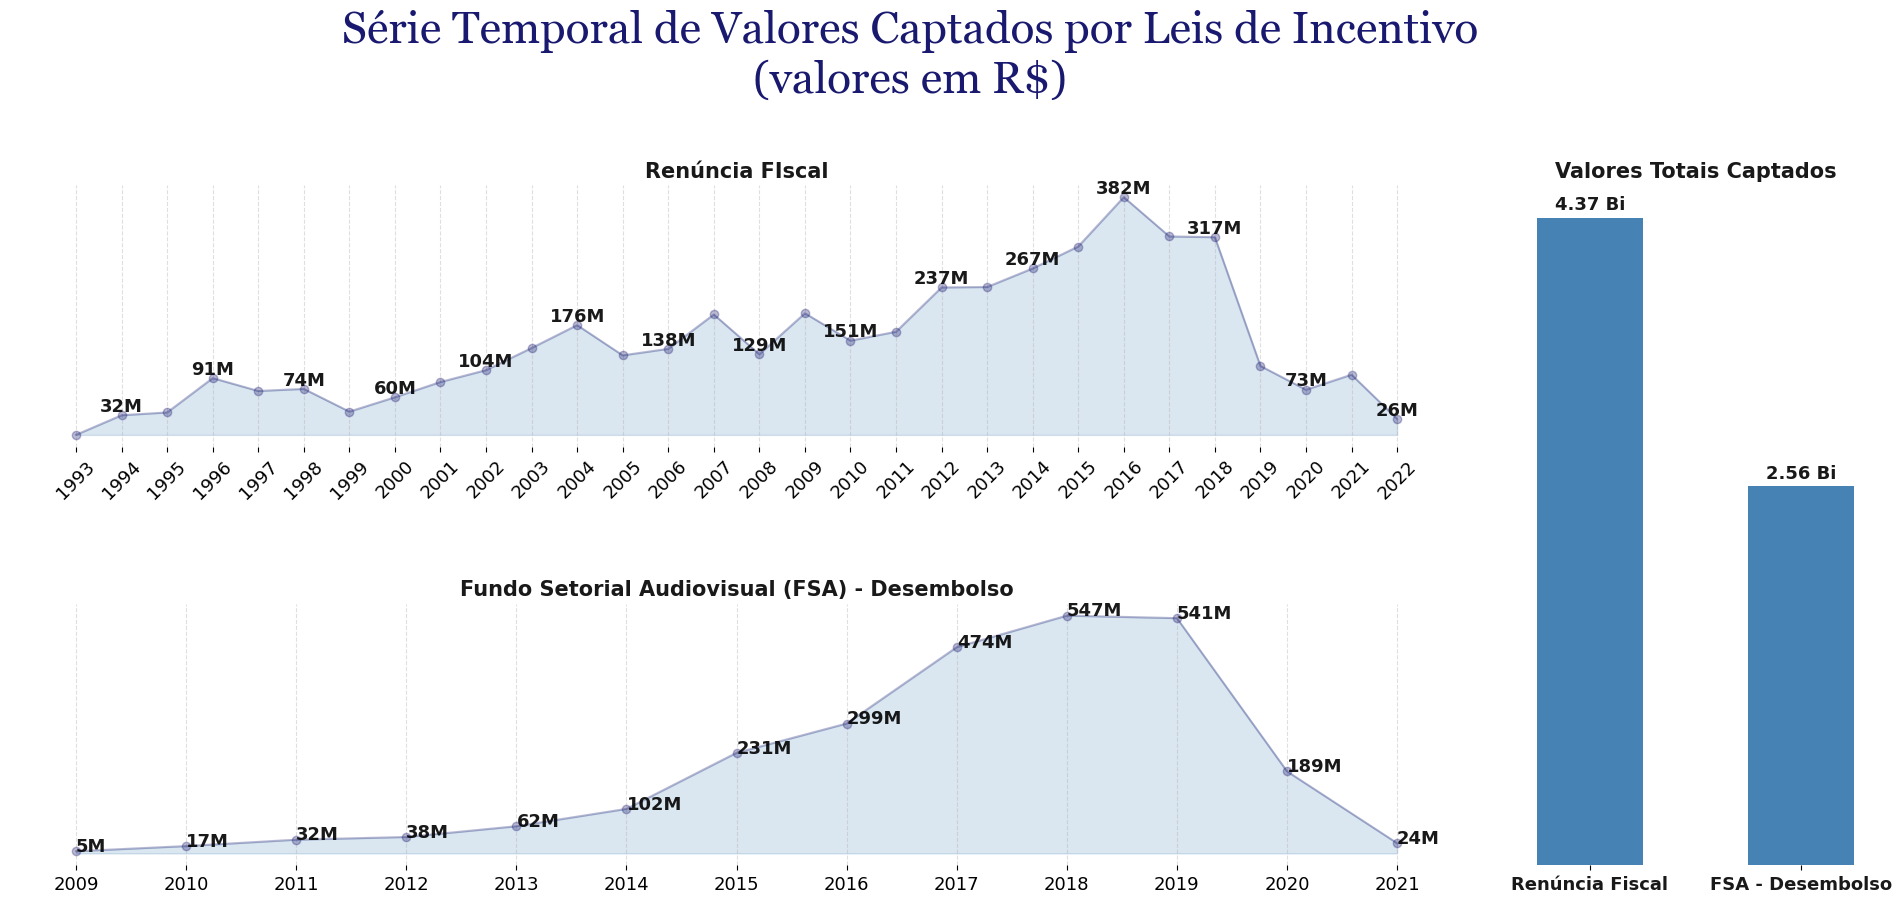

In [59]:
df_serie_temp_renun_fiscal = proj_renuncia_fiscal[['DT_APROVACAO_CAPTACAO', 'TOTAL_CAPTADO']]
df_serie_temp_renun_fiscal['TOTAL_CAPTADO'] = df_serie_temp_renun_fiscal['TOTAL_CAPTADO'].str.replace(',', '.').astype(float)
df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'] = df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'].dt.year
df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']
df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.groupby(df_serie_temp_renun_fiscal.index).sum().reset_index()
df_serie_temp_renun_fiscal_ano = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']

df_serie_temp_fsa_desembolso = proj_fsa_desembolso[['DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]
df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'] = df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = pd.to_datetime(df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'], errors='coerce')
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.dropna(subset=['DT_PRIMEIRO_DESEMBOLSO'])
df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].dt.year.astype(int)
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.groupby(df_serie_temp_fsa_desembolso.index).sum().reset_index()
df_serie_temp_fsa_desembolso_ano = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']

total_fsa_desembolso = df_serie_temp_fsa_desembolso_ano.sum()
total_renun_fiscal = df_serie_temp_renun_fiscal_ano.sum()

def grafico_fsa_renuncia_fiscal():

    #
    fig = plt.figure(figsize=(24,8))
    axs = [None for _ in range(3)]
    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1])
    axs[0] = fig.add_subplot(gs[0, :-1])
    axs[1] = fig.add_subplot(gs[1, :-1])
    axs[2] = fig.add_subplot(gs[0:, -1])



    def valor_index(df, numero):
        count = 0
        for index, valor in df.items():
            milhoes = valor / 1e6
            
            if numero == 0:
                count += 1 
                if count % 2 == 0:
                    axs[0].text(index, valor, f"{milhoes:.0f}M", ha='center', va='bottom', fontweight='bold', fontsize=13, color='k', alpha=0.9)
                else:
                    continue
            else:
                axs[1].text(index, valor, f"{milhoes:.0f}M", fontweight='bold', fontsize=13, color='k', alpha=0.9)

    valor_index(df_serie_temp_fsa_desembolso_ano, 1)
    valor_index(df_serie_temp_renun_fiscal_ano, 0)

    axs[0].plot(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color='midnightblue', marker='o', alpha=0.3, label='Serie Temp Renun Fiscal Ano')
    axs[0].set_xticks(df_serie_temp_renun_fiscal_ano.index)
    axs[0].set_xticklabels(df_serie_temp_renun_fiscal_ano.index, rotation=45, fontweight='light', alpha=1)
    axs[0].fill_between(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color="steelblue", alpha=0.2)
    axs[0].tick_params(axis='x', which='minor', width=5)
    axs[0].set_yticks([])
    axs[0].grid(linestyle='dashed', alpha=0.4)
    axs[0].set_title('Renúncia FIscal', fontsize=15, fontweight='bold', alpha=0.9 )

    axs[1].plot(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color='midnightblue', marker='o', alpha=0.3, label='Serie Temp Fsa Desembolso Ano')      
    axs[1].set_xticks(df_serie_temp_fsa_desembolso_ano.index)
    axs[1].set_xticklabels(df_serie_temp_fsa_desembolso_ano.index, rotation=0, fontweight='light', alpha=1)
    axs[1].fill_between(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color="steelblue", alpha=0.2)
    axs[1].tick_params(axis='x', which='minor', width=5)
    axs[1].set_yticks([])
    axs[1].grid(linestyle='dashed', alpha=0.4)
    axs[1].set_title('Fundo Setorial Audiovisual (FSA) - Desembolso', fontsize=15, fontweight='bold', alpha=0.9 )


    # Plotting for axs[2]

    axs[2].bar(['Renúncia Fiscal', 'FSA - Desembolso'], [total_renun_fiscal, total_fsa_desembolso], width=0.5, color='steelblue')
    for rect in axs[2].patches:
        height = rect.get_height()
        value_in_billions = height / 1e9  # Convert value to billions
        rounded_value = round(value_in_billions, 2)  # Round to one decimal place
        annot_text = f'{rounded_value:,.2f} Bi'
        axs[2].annotate(annot_text, xy=(rect.get_x() + rect.get_width() / 2  , height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold', fontsize=13, alpha=0.9)
    axs[2].set_xticklabels(['Renúncia Fiscal', 'FSA - Desembolso'], rotation=0, fontweight='bold', alpha=0.9) 
    axs[2].set_title('Valores Totais Captados', fontsize=15, fontweight='bold', alpha=0.9)
    # Set tick parameters and labels
    for ax_single in axs:
        ax_single.tick_params(axis='both', which='major', labelsize=13) 
        ax_single.set_ylabel(None)  
        ax_single.set_yticks([])

    # Remove spines
    for ax_single in axs:
        ax_single.spines['top'].set_visible(False)
        ax_single.spines['right'].set_visible(False)
        ax_single.spines['bottom'].set_visible(False)
        ax_single.spines['left'].set_visible(False)

    # Adjust the spacing around subplots
    plt.subplots_adjust(top=0.95, bottom=0.1, wspace=0.1, hspace=0.6)

    # Add title
    fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
    plt.suptitle('Série Temporal de Valores Captados por Leis de Incentivo\n(valores em R$)', fontdict=fontprops, fontsize=32, y=1.17)
    # Show the plot
    plt.show()

grafico_fsa_renuncia_fiscal()

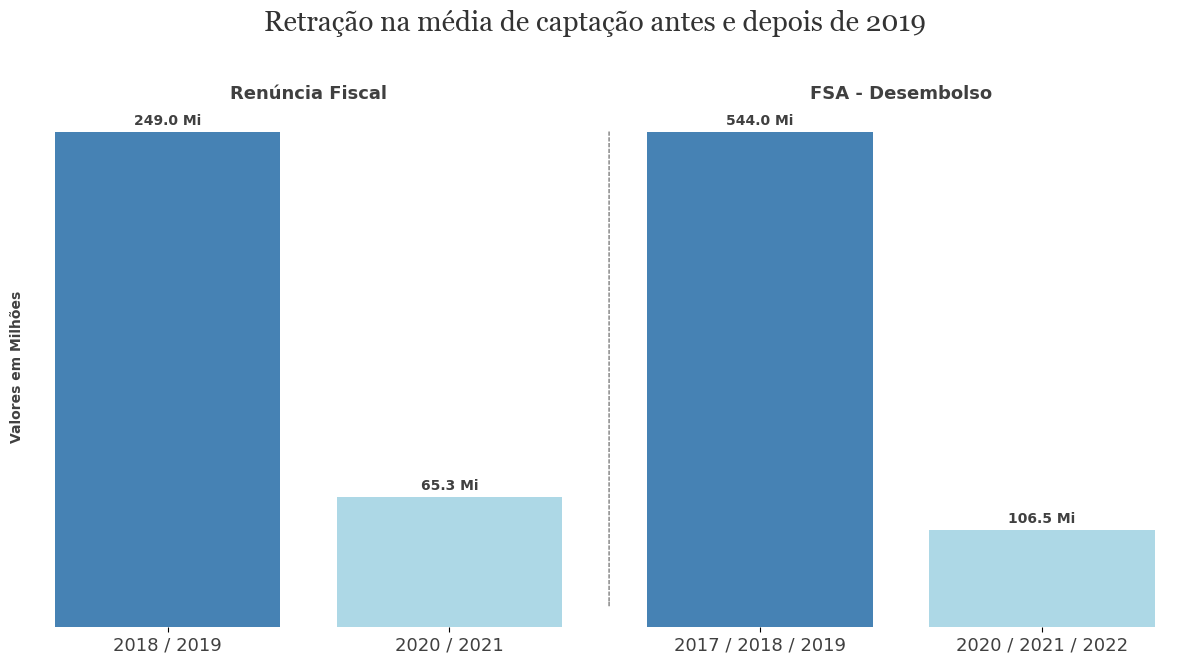

In [61]:
def retracao_media_antes_e_depois_2019(): 
   # Dados
    total_renun_fiscal_balanco = {
        'pre_2019': 249,
        'pos_2019': 65.3
    }

    total_fsa_desembolso_balanco = {
        'pre_2019': 544,
        'pos_2019': 106.5
    }

    # Preparando os dados para os gráficos
    categories_1 = ['2018 / 2019', '2020 / 2021']
    categories_2 = ['2017 / 2018 / 2019', '2020 / 2021 / 2022']
    renuncia_fiscal = [total_renun_fiscal_balanco['pre_2019'], total_renun_fiscal_balanco['pos_2019']]
    fsa_desembolso = [total_fsa_desembolso_balanco['pre_2019'], total_fsa_desembolso_balanco['pos_2019']]

    x_1 = np.arange(len(categories_1))  # Posições das categorias
    x_2 = np.arange(len(categories_2))  # Posições das categorias
    width = 0.8  # Largura das barras

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Cores para as barras
    colors_ = ['darkgreen', 'darkred']
    colors = ['steelblue', 'lightblue']

    # Gráfico de Renúncia Fiscal
    bars1 = axs[0].bar(x_1, renuncia_fiscal, width, color=colors)
    bars2 = axs[1].bar(x_2, renuncia_fiscal, width, color=colors)

    # Adicionando os valores no topo das barras
    def add_value_labels(ax, bars):
        for bar in bars:
            height = bar.get_height()
            annot_text = f'{height:,.1f} Mi'
            ax.annotate(annot_text,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 pontos de deslocamento vertical
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold', fontsize=10, alpha=0.75)

    add_value_labels(axs[0], bars1)

    # Configurações do gráfico de Renúncia Fiscal
    # axs[0].set_xlabel('Período', fontweight='bold', alpha=0.75)
    axs[0].set_ylabel('Valores em Milhões', fontweight='bold', alpha=0.75)
    axs[0].set_title('Renúncia Fiscal', fontsize=13, fontweight='bold', alpha=0.75)
    axs[0].set_xticks(x_1)
    axs[0].set_xticklabels(categories_1, rotation=0, fontweight='normal', alpha=0.75)

    # Gráfico de FSA - Desembolso
    bars2 = axs[1].bar(x_1, fsa_desembolso, width, color=colors)

    # Adicionando os valores no topo das barras
    add_value_labels(axs[1], bars2)

    # Configurações do gráfico de FSA - Desembolso
    # axs[1].set_xlabel('Período', fontweight='bold', alpha=0.75)
    axs[1].set_ylabel('-----------------------------------------------------------------------------------', fontweight='bold', alpha=0.4)
    axs[1].set_title('FSA - Desembolso', fontsize=13, fontweight='bold', alpha=0.75)
    axs[1].set_xticks(x_2)
    axs[1].set_xticklabels(categories_2, rotation=0, fontweight='normal', alpha=0.75)

    # Ajustes nas grades e eixos
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

    # Ajustando o layout
    plt.tight_layout()

    # Adicionando título geral
    fontprops = {'color': 'black', 'weight': 'bold', 'style': 'normal', 'family': 'Georgia'}
    plt.suptitle('Retração na média de captação antes e depois de 2019', fontdict=fontprops, fontsize=20, alpha=0.8, y=1.10)

    # Mostrando o gráfico
    plt.show()

retracao_media_antes_e_depois_2019()

---

## 3. Análise Estatística

### Perfil estatístico

In [35]:
#Função que retorna dados estatísticos
def stats_df(df):

    numerical = df.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))

    media = pd.DataFrame(numerical.mean()).T
    mediana = pd.DataFrame(numerical.median()).T

    desvio_padrao = pd.DataFrame(numerical.apply(np.std)).T
    minimo = pd.DataFrame(numerical.min()).T
    maximo = pd.DataFrame(numerical.max()).T
    range = pd.DataFrame(numerical.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(numerical.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(numerical.apply(lambda x: x.kurtosis())).T

    nome_stats_df = 'stats_' + str(df)
    nome_stats_df = pd.concat([media, mediana, desvio_padrao, minimo, maximo, range, skew, kurtosis]).T.reset_index()

    if df is fsa_desembolso:
        nome_df = 'FSA - Desembolso'
    else:
        nome_df = 'Renúncia Fiscal'
    nome_stats_df.columns = [nome_df, 'Média', 'Mediana', 'Desvio Padrão', 'Mínimo', 'Máximo', 'Range', 'Skew', 'Kurtosis']
    return nome_stats_df


3.3 Atributos Numéricos

In [36]:
#Função que retorna gráfico Histogram

fsa_desembolso_numerical = fsa_desembolso.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))
renuncia_fiscal_numerical = renuncia_fiscal.select_dtypes(exclude=('datetime64[ns]', 'object', 'bool'))


def plot_hist_renuncia_fiscal():

    fig = plt.figure(figsize=(18,10))
    axs = [None] * 4
    gs = gridspec.GridSpec(2, 2)
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[1,0])
    axs[3] = fig.add_subplot(gs[1,1])

    n_bins = 40

    labels = {
        'CLASSIFICACAO_NIVEL_PRODUTORA' : 'Nível de Classificação',
        'ANO_CHAMADA_PUBLICA' : 'Ano da Chamada Pública',
        'VL_CONTRATO_DOU' : 'Valor do Contrato',
        'VL_TOTAL_LIBERADO' : 'Valor Liberado',
    }

    #Plot Hist - Renúncia Fiscal
    for i, column in enumerate(['CLASSIFICACAO_NIVEL_PRODUTORA', 'ANO_CHAMADA_PUBLICA', 'VL_CONTRATO_DOU', 'VL_TOTAL_LIBERADO']):
        sns.histplot(fsa_desembolso_numerical[column], bins=n_bins, kde=True, ax=axs[i], 
                     stat='percent', line_kws={'color': 'red'})
        axs[i].set_title(labels[column])
        axs[i].set_xlabel(None)


    plt.tight_layout()
    plt.show()

def plot_hist_fsa_desembolso():
    
    fig = plt.figure(figsize=(16,12))
    axs = [None] * 8
    gs = gridspec.GridSpec(4, 3)
    axs[0] = fig.add_subplot(gs[0,0])
    axs[1] = fig.add_subplot(gs[0,1])
    axs[2] = fig.add_subplot(gs[1,0])
    axs[3] = fig.add_subplot(gs[1,1])
    axs[4] = fig.add_subplot(gs[2,0])
    axs[5] = fig.add_subplot(gs[2,1])
    axs[6] = fig.add_subplot(gs[3,0])
    axs[7] = fig.add_subplot(gs[3,1])

    n_bins = 40

    labels = {
        'LEI_8313' : 'Lei 8313 (Lei Rouanet)',
        'ART1' : 'Artigo 1°',
        'ART1A' : 'Artigo 1°.A',
        'ART3' : 'Artigo 3°',
        'ART3A' : 'Artigo 3°.A',
        'ART39' : 'Artigo 39°',
        'FUNCINES' : 'FUNCINES - Fundo Municipal de Cinema',
        'TOTAL_CAPTADO' : 'Total Captado',
    }
    #Plot Hist - FSA - Desembolso
    for i, column in enumerate(['LEI_8313', 'ART1',
        'ART1A', 'ART3', 'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO']):
        sns.histplot(renuncia_fiscal_numerical[column], bins=n_bins, kde=True, ax=axs[i], stat='percent')
        axs[i].set_title(labels[column])
        axs[i].set_xlabel(None)
    # plt.box([])
    plt.tight_layout()
    plt.show()

3.4 Atributos Categóricos

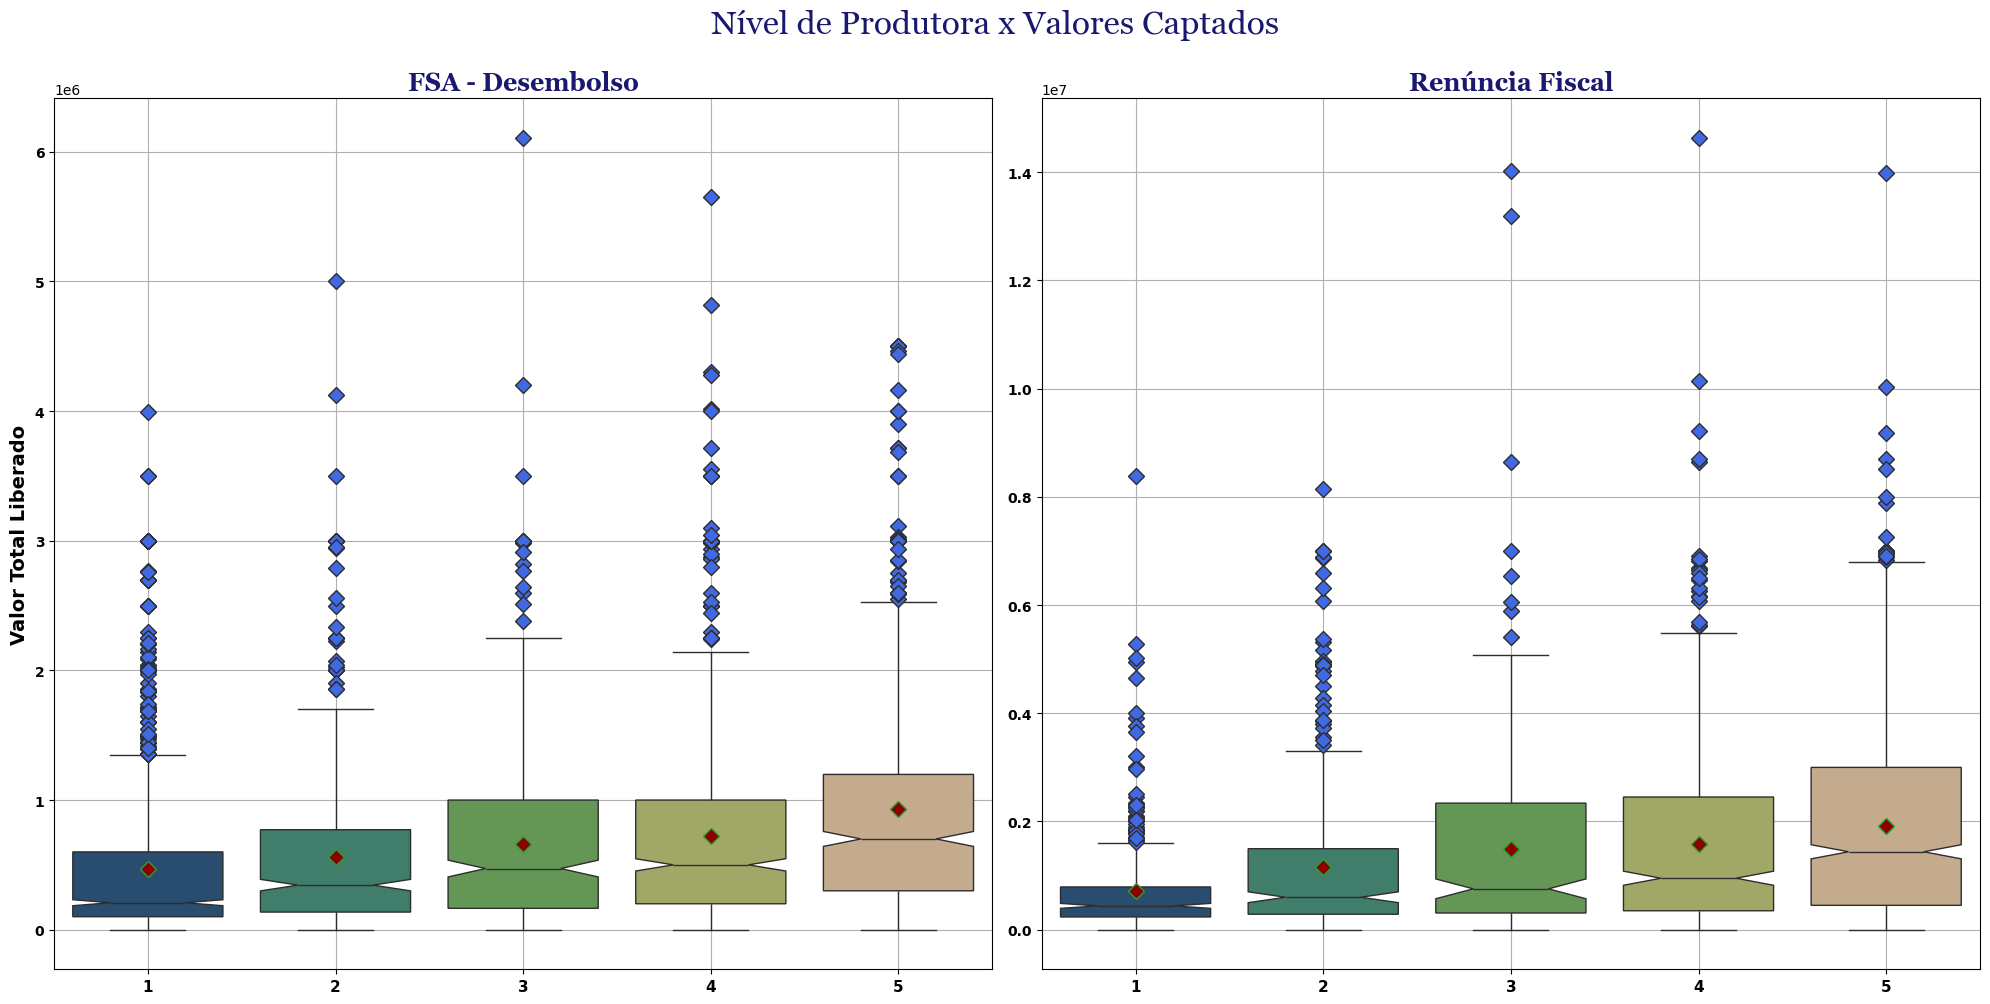

In [37]:
#Boxplot - Atributos Categóricos
data_fsa = fsa_desembolso
data_renuncia = renuncia_fiscal

fig = plt.figure(figsize=(20,10))
axs = [None] * 2
gs = gridspec.GridSpec(1, 2)
axs[0] = fig.add_subplot(gs[0,0])
axs[1] = fig.add_subplot(gs[0,1])

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
flierprops = dict(marker='D', markerfacecolor='royalblue', markersize=8, linestyle='none')
meanprops = dict(marker='D', markerfacecolor='darkred', markersize=8)

axs[0] = plt.subplot(1, 2, 1)
sns.boxplot(x='CLASSIFICACAO_NIVEL_PRODUTORA', y='VL_TOTAL_LIBERADO', data=data_fsa, 
            notch=True, showmeans=True, meanprops=meanprops, 
            palette='gist_earth', flierprops=flierprops)
axs[0] = plt.xticks(fontweight='bold', fontsize=11)
axs[0] = plt.ylabel('Valor Total Liberado', fontweight='bold', fontsize=14)
axs[0] = plt.title('FSA - Desembolso', fontdict=fontprops, fontsize=18)
# axs[0] = plt.box(None)
axs[0] = plt.grid(None)
axs[0] = plt.yticks(fontsize=10, fontweight='bold')
axs[0] = plt.xlabel(None)

axs[1] =  plt.subplot(1, 2, 2)
sns.boxplot(x='CLASSIFICACAO_NIVEL_PRODUTORA', y='TOTAL_CAPTADO', data=data_renuncia, 
            notch=True, showmeans=True, meanprops=meanprops,
              palette='gist_earth', flierprops=flierprops)
axs[1] = plt.xticks(fontweight='bold', fontsize=11)
axs[1] = plt.ylabel(None)
axs[1] = plt.title('Renúncia Fiscal', fontdict=fontprops, fontsize=18)
# axs[1] = plt.box(None)
axs[1] = plt.grid(None)
axs[1] = plt.yticks(fontsize=10, fontweight='bold')
axs[1] = plt.xlabel(None)

plt.suptitle('Nível de Produtora x Valores Captados', fontdict=fontprops, fontsize=24, y=1.0)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

### Padronização  

##### FSA / Desembolso  
    * Criar Coluna com a soma de dias passados entre a data de aprovação e a data do primerio desembolso
    * Padronizar coluna CHAMADA_PUBLICA
    * Criar coluna numérica da CHAMADA_PUBLICA e NATUREZA_JURIDICA

In [38]:
fsa_ml_padrao = fsa_desembolso.copy()
fsa_ml_padrao = fsa_desembolso[['REGISTRO_ANCINE', 'RAZAO_SOCIAL', 'UF', 'TITULO_PROJETO', 'NATUREZA_JURIDICA','CHAMADA_PUBLICA','DT_PUBLICACAO_CONTRATO_DOU', 'VL_CONTRATO_DOU', 'DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]

fsa_ml_padrao['TEMPO_DESEMBOLSO'] = np.array(fsa_ml_padrao['DT_PRIMEIRO_DESEMBOLSO'] - fsa_ml_padrao['DT_PUBLICACAO_CONTRATO_DOU'])

fsa_ml_padrao = fsa_ml_padrao[
    fsa_ml_padrao['TEMPO_DESEMBOLSO'] > pd.Timedelta(0)
]

fsa_ml_padrao['TEMPO_DESEMBOLSO'] = fsa_ml_padrao['TEMPO_DESEMBOLSO'].dt.days
fsa_ml_padrao['TEMPO_DESEMBOLSO'] = np.array(fsa_ml_padrao['TEMPO_DESEMBOLSO'])
fsa_ml_padrao.sort_values(by='TEMPO_DESEMBOLSO', ascending=False)

#Transformar variavel CHAMADA_PUBLICA em numeral
chamadas = {
'COMERCIALIZAÇÃO EM CINEMA' : 'Comercialização',
 'PRODECINE 01' : 'PRODECINE',
 'PRODECINE 04' : 'PRODECINE',
 'PRODAV 05' : 'PRODAV',
 'CRÉDITO EMERGENCIAL FSA' : 'Crédito Emergencial',
 'PRODAV 03' : 'PRODAV',
 'PRODAV 01' : 'PRODAV',
 'ARRANJOS REGIONAIS' : 'Arranjos Regionais',
 'PRODAV 06' : 'PRODAV',
 'PRODAV 02 - PROJETO DERIVADO' : 'PRODAV',
 'PRODAV 11' : 'PRODAV',
 'PRODAV 13' : 'PRODAV',
 'SUPORTE AUTOMÁTICO - DESEMPENHO COMERCIAL TV E VOD' : 'Suporte Automático',
 'COPRODUÇÃO INTERNACIONAL': 'Coprodução Internacional',
 'PRODECINE 02' : 'PRODECINE',
 'PRODECINE 05' : 'PRODECINE',
 'PRODECINE 03' : 'PRODECINE',
 'PRODAV 10' : 'PRODAV',
 'FLUXO CONTÍNUO PRODUÇÃO PARA CINEMA' : 'Fluxo Contínuo',
 'SUPORTE AUTOMÁTICO - DESEMPENHO COMERCIAL CINEMA' : 'Suporte Automático',
 'CONCURSO PRODUÇÃO PARA CINEMA' : 'Concurso',
 'SAV/MINC 11' : 'SAV/MINC',
 'PRODAV 07' : 'PRODAV',
 'SAV/MINC 09' : 'SAV/MINC',
 'SAV/MINC 04' : 'SAV/MINC',
 'PRODAV 09' : 'PRODAV',
 'SAV/MINC 10' : 'SAV/MINC',
 'PRODAV 12' : 'PRODAV',
 'PRODAV 04' : 'PRODAV',
 'PRODAV 07/SUPORTE AUTOMÁTICO - DESEMPENHO COMERCIAL CINEMA' : 'PRODAV',
 'PRODAV 06/SUPORTE AUTOMÁTICO - DESEMPENHO COMERCIAL CINEMA' : 'PRODAV',
 'PRODECINE 06' : 'PRODECINE',
 'PRODECINE 12' : 'PRODECINE',
 'SUPORTE AUTOMÁTICO - DESEMPENHO ARTÍSTICO' : 'Suporte Automático',
 'SAV/MINC 13' : 'SAV/MINC',
 'FLUXO CONTÍNUO PRODUÇÃO PARA TELEVISÃO' :'Fluxo Contínuo',
 'PRODECINE 08' : 'PRODECINE',
 'PRODAV 06/PRODAV 07' : 'PRODAV',
 'SAV/MINC 03' : 'SAV/MINC',
 'SAV/MINC 01' : 'SAV/MINC',
 'PRODAV - TVS PÚBLICAS' : 'PRODAV',
 'SAV/MINC 02' : 'SAV/MINC',
 'SAV/MINC 08' : 'SAV/MINC',
 'PRODECINE 07' : 'PRODECINE',
 'PRODAV 08' : 'PRODAV',
 'PROGRAMA ESPECIAL DE APOIO AO PEQUENO EXIBIDOR \x96 PEAPE' : 'Programa Especial',
 'SAV/MINC 05' : 'SAV/MINC',
 'PRODECINE 09' : 'PRODECINE',
 'PRODAV 14' : 'PRODAV',
 'SAV/MINC 06' : 'SAV/MINC',
 'SAV/MINC 07' : 'SAV/MINC',
 'PRODECINE 10' : 'PRODECINE'
}

fsa_ml_padrao['CHAMADA_PUBLICA'] = fsa_ml_padrao['CHAMADA_PUBLICA'].replace(chamadas)


fsa_ml_padrao['CHAMADA_PUBLICA_encoded'] = pd.factorize(fsa_ml_padrao['CHAMADA_PUBLICA'])[0]

fsa_ml_padrao['NATUREZA_JURIDICA_encoded'] = pd.factorize(fsa_ml_padrao['NATUREZA_JURIDICA'])[0]

fsa_ml_padrao['UF_encoded'] = pd.factorize(fsa_ml_padrao['UF'])[0]


##### Renúncia Fiscal
    * Criar Coluna com a soma de dias passados entre a data de aprovação e a data da liberação
    * Padronizar coluna NATUREZA_JURIDICA
    * Criar coluna numérica da UF, NATUREZA_JURIDICA

In [39]:
re_fiscal_ml = produtoras_proj_renun_fiscal.copy()


re_fiscal_ml = re_fiscal_ml[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'CNPJ',
       'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
       'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_NIVEL_PRODUTORA', 'LEI_8313', 'ART1', 'ART1A', 'ART3', 'ART3A', 'ART39',
       'FUNCINES', 'TOTAL_CAPTADO', 'DT_APROVACAO_CAPTACAO', 'DT_1_LIBERACAO']]

##
re_fiscal_ml['TEMPO_DESEMBOLSO'] = np.array(re_fiscal_ml['DT_1_LIBERACAO'] - re_fiscal_ml['DT_APROVACAO_CAPTACAO'])

re_fiscal_ml = re_fiscal_ml[
    re_fiscal_ml['TEMPO_DESEMBOLSO'] > pd.Timedelta(0)
]

re_fiscal_ml['TEMPO_DESEMBOLSO'] = re_fiscal_ml['TEMPO_DESEMBOLSO'].dt.days
re_fiscal_ml['TEMPO_DESEMBOLSO'] = np.array(re_fiscal_ml['TEMPO_DESEMBOLSO'])


##
vol_valores = [
        'LEI_8313', 'ART1', 'ART1A', 'ART3',
       'ART3A', 'ART39', 'FUNCINES', 'TOTAL_CAPTADO']

for col in vol_valores:
    re_fiscal_ml[col] = re_fiscal_ml[col].str.replace(',', '.').astype(float)


##
col_factorize = ['UF', 
                 'MUNICIPIO', 
                 'NATUREZA_JURIDICA', 
                 'ATIVIDADE_ECONOMICA']


for col in col_factorize:
    col_name = col + '_encoded'
    re_fiscal_ml[col_name] = pd.factorize(re_fiscal_ml[col])[0]




### Outliers

##### FSA / Desembolso
    * Remoção dos 5% de valores extremos, retendo 95% dos dados

In [40]:
# Lista de UF's
ufs = ['RJ', 'SP', 'DF', 'SC', 'RS', 'BA', 'MG', 'PE', 'GO', 'CE', 'PR',
       'PB', 'MT', 'PA', 'AM', 'RN', 'AL', 'PI', 'SE', 'AP', 'ES', 'MA',
       'MS', 'TO', 'RO', 'AC', 'RR']

# Iterando sobre cada UF na lista
for uf in ufs:
    # Filtrando os dados para a UF atual
    query_uf = fsa_ml_padrao.query('UF == @uf')
    
    # Calculando o percentil de 95% para a coluna 'TEMPO_DESEMBOLSO'
    percentil_95 = np.percentile(query_uf['TEMPO_DESEMBOLSO'], 95)
    fsa_ml_padrao = fsa_ml_padrao[~((fsa_ml_padrao['UF'] == uf) & (fsa_ml_padrao['TEMPO_DESEMBOLSO'] > percentil_95))]
    


##### Renúncia Fiscal
    * Remoção dos 5% de valores extremos, retendo 95% dos dados


In [41]:
# Lista de UF's
ufs = re_fiscal_ml['UF'].unique()

# Iterando sobre cada UF na lista
for uf in ufs:
    # Filtrando os dados para a UF atual
    query_uf = re_fiscal_ml.query('UF == @uf')
    
    # Calculando o percentil de 95% para a coluna 'TEMPO_DESEMBOLSO'
    percentil_95 = np.percentile(query_uf['TEMPO_DESEMBOLSO'], 99)
    re_fiscal_ml = re_fiscal_ml[~((re_fiscal_ml['UF'] == uf) & (re_fiscal_ml['TEMPO_DESEMBOLSO'] > percentil_95))]
    


#### Gráficos descritivos

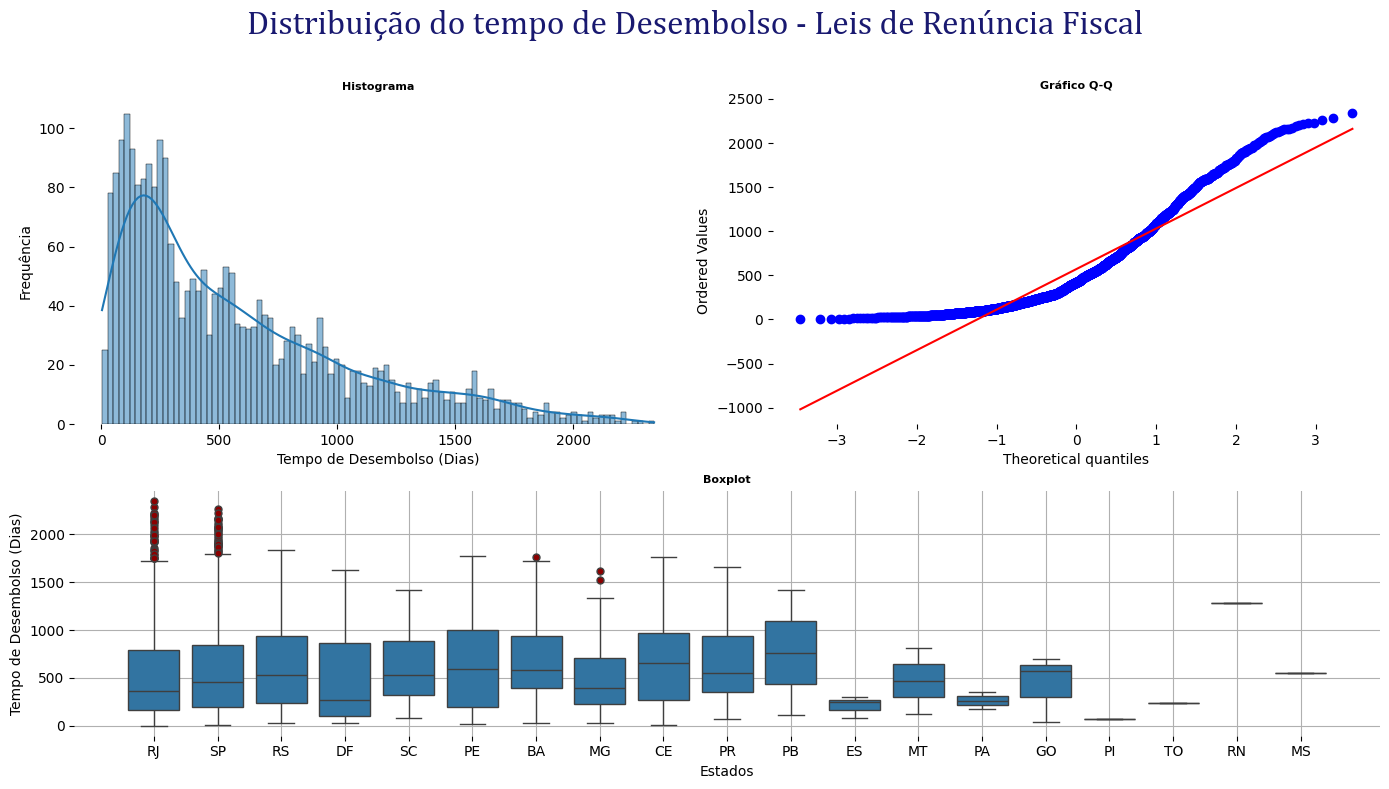

In [62]:
# Plot com 3 plots = boxplot, histogram e gráfico q-q

# Criar a figura
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[4, 3], width_ratios=[2, 2])
# Plotar mapa dos estados sem SP e RJ
ax1 = plt.subplot(gs[0,0])
sns.histplot(re_fiscal_ml['TEMPO_DESEMBOLSO'], bins=100, kde=True)
ax1.set_title('Histograma', fontweight='bold', fontsize=8)
ax1.set_xlabel('Tempo de Desembolso (Dias)')
ax1.set_ylabel('Frequência')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

quantile_95 = np.percentile(re_fiscal_ml['TEMPO_DESEMBOLSO'], 95)
# ax1.axvline(x=quantile_95, color='red', linestyle='--', linewidth=1, label='Quantil de 95%')

##########

# Plotar mapa dos estados com SP e RJ


ax2 = plt.subplot(gs[0,1])
stats.probplot(re_fiscal_ml['TEMPO_DESEMBOLSO'], dist="norm", plot=plt)
ax2.set_title('Gráfico Q-Q', fontweight='bold', fontsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#############

# Plotar gráfico de barras
flierprops = dict(marker='o', color='darkblue', markerfacecolor='darkred', markersize=5)


ax3 = plt.subplot(gs[1, :])
sns.boxplot(x='UF', y='TEMPO_DESEMBOLSO', data=re_fiscal_ml, ax=ax3, flierprops=flierprops)
# for p in ax3.patches:
#     ax3.annotate( 
#                    ha='center', va='center', 
#                    xytext=(0, 8), 
#                    textcoords='offset points',
#                    fontsize=9, fontweight='bold')
ax3.set_title('Boxplot', fontweight='bold', fontsize=8)
ax3.set_xlabel('Estados')
ax3.set_ylabel('Tempo de Desembolso (Dias)')
ax3.margins(0.045)
plt.tight_layout()
ax3.grid(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

##############

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Cambria'}

plt.suptitle('Distribuição do tempo de Desembolso - Leis de Renúncia Fiscal', fontdict=fontprops, fontsize=24)
plt.subplots_adjust(top=0.87)
plt.show()


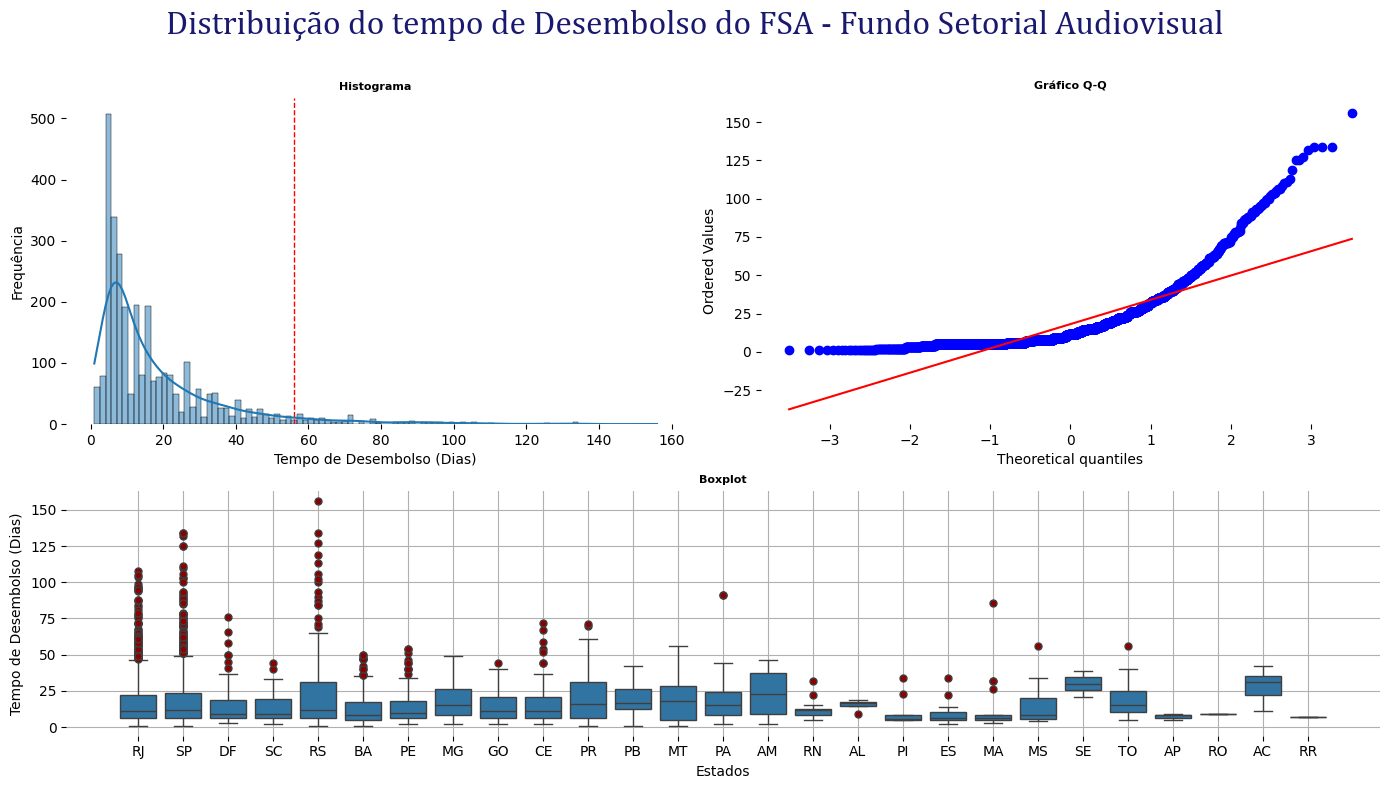

In [43]:
# Plot com 3 plots = boxplot, histogram e gráfico q-q

# Criar a figura
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[4, 3], width_ratios=[2, 2])
# Plotar mapa dos estados sem SP e RJ
ax1 = plt.subplot(gs[0,0])
sns.histplot(fsa_ml_padrao['TEMPO_DESEMBOLSO'], bins=100, kde=True)
ax1.set_title('Histograma', fontweight='bold', fontsize=8)
ax1.set_xlabel('Tempo de Desembolso (Dias)')
ax1.set_ylabel('Frequência')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

quantile_95 = np.percentile(fsa_ml_padrao['TEMPO_DESEMBOLSO'], 95)
ax1.axvline(x=quantile_95, color='red', linestyle='--', linewidth=1, label='Quantil de 95%')

##########

# Plotar mapa dos estados com SP e RJ


ax2 = plt.subplot(gs[0,1])
stats.probplot(fsa_ml_padrao['TEMPO_DESEMBOLSO'], dist="norm", plot=plt)
ax2.set_title('Gráfico Q-Q', fontweight='bold', fontsize=8)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#############

# Plotar gráfico de barras
flierprops = dict(marker='o', color='darkblue', markerfacecolor='darkred', markersize=5)

ax3 = plt.subplot(gs[1, :])
sns.boxplot(x='UF', y='TEMPO_DESEMBOLSO', data=fsa_ml_padrao, ax=ax3, flierprops=flierprops)
# for p in ax3.patches:
#     ax3.annotate( 
#                    ha='center', va='center', 
#                    xytext=(0, 8), 
#                    textcoords='offset points',
#                    fontsize=9, fontweight='bold')
ax3.set_title('Boxplot', fontweight='bold', fontsize=8)
ax3.set_xlabel('Estados')
ax3.set_ylabel('Tempo de Desembolso (Dias)')
ax3.margins(0.045)
plt.tight_layout()
ax3.grid(True)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

##############

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Cambria'}

plt.suptitle('Distribuição do tempo de Desembolso do FSA - Fundo Setorial Audiovisual', fontdict=fontprops, fontsize=24)
plt.subplots_adjust(top=0.87)
plt.show()


#### Visualização

In [44]:
def stats_tempo_desembolso(df):
    numerical = df.select_dtypes(include=('int64', 'float64'))

    media = pd.DataFrame(numerical.mean().round().apply(lambda x: f'{x:,.2f}')).T
    mediana = pd.DataFrame(numerical.median().round().apply(lambda x: f'{x:,.2f}')).T
    moda = pd.DataFrame(numerical.mode().iloc[0]).T
    desvio_padrao = pd.DataFrame(numerical.apply(np.std).round().apply(lambda x: f'{x:,.2f}')).T
    minimo = pd.DataFrame(numerical.min()).T
    maximo = pd.DataFrame(numerical.max().apply(lambda x: f'{x:,.2f}')).T
    quantile_1 = pd.DataFrame(numerical.quantile(0.25)).T
    quantile_2 = pd.DataFrame(numerical.quantile(0.50)).T
    quantile_3 = pd.DataFrame(numerical.quantile(0.75)).T
    range = pd.DataFrame(numerical.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(numerical.apply(lambda x: x.skew()).apply(lambda x: f'{x:.3f}')).T
    kurtosis = pd.DataFrame(numerical.apply(lambda x: x.kurtosis()).apply(lambda x: f'{x:.3f}')).T

  
    nome_df = '_stats'
    stats_df = pd.concat([media, mediana, moda, desvio_padrao, minimo, maximo, range, quantile_1, quantile_2, quantile_3, skew, kurtosis]).T.reset_index()
    # Definir os nomes das colunas
    stats_df.columns = [nome_df, 'Média', 'Mediana', 'Moda', 'Desvio Padrão', 'Mínimo', 'Máximo', 'Range', '25%', '50%', '75%', 'Skew', 'Kurtosis']  
    return stats_df

In [45]:
stats_tempo_desembolso(re_fiscal_ml)

,_stats,Média,Mediana,Moda,Desvio Padrão,Mínimo,Máximo,Range,25%,50%,75%,Skew,Kurtosis
0,REGISTRO_ANCINE,"6,769.00","1,304.00",848.0,"9,384.00",1.0,"49,195.00",49194.0,572.0,1304.0,13445.25,1.547,1.742
1,CLASSIFICACAO_NIVEL_PRODUTORA,4.00,4.00,5.0,1.00,1.0,5.00,4.0,2.0,4.0,5.0,-0.578,-1.075
2,LEI_8313,"77,512.00",0.00,0.0,"269,295.00",0.0,"3,313,201.01",3313201.0071,0.0,0.0,0.0,5.157,33.814
3,ART1,"252,504.00",0.00,0.0,"576,385.00",0.0,"4,000,000.00",4000000.0,0.0,0.0,200000.0,3.008,9.550
4,ART1A,"285,627.00",0.00,0.0,"569,139.00",0.0,"4,000,000.00",4000000.0,0.0,0.0,350000.0,2.964,10.697
5,ART3,"236,599.00",0.00,0.0,"670,171.00",0.0,"3,988,084.11",3988084.11,0.0,0.0,0.0,3.117,8.832
6,ART3A,"392,862.00",0.00,0.0,"841,930.00",0.0,"3,000,000.00",3000000.0,0.0,0.0,230000.0,2.229,3.629
7,ART39,"253,806.00",0.00,0.0,"1,042,217.00",0.0,"14,634,931.60",14634931.6,0.0,0.0,0.0,6.994,63.409
8,FUNCINES,"24,926.00",0.00,0.0,"218,646.00",0.0,"6,000,000.00",6000000.0,0.0,0.0,0.0,15.238,314.106
9,TOTAL_CAPTADO,"1,523,836.00","825,684.00",3000000.0,"1,675,980.00",0.0,"14,634,931.60",14634931.6,321027.875,825684.235,2317011.85,2.052,6.683


In [46]:
stats_tempo_desembolso(fsa_ml_padrao)

,_stats,Média,Mediana,Moda,Desvio Padrão,Mínimo,Máximo,Range,25%,50%,75%,Skew,Kurtosis
0,REGISTRO_ANCINE,"12,479.00","13,148.00",848.0,"10,878.00",3.0,"46,335.00",46332.0,1405.0,13148.0,20809.0,0.460,-0.940
1,VL_CONTRATO_DOU,"651,657.00","400,000.00",100000.0,"716,119.00",5853.11,"6,107,400.00",6101546.89,156000.0,400000.0,940687.75,2.337,7.332
2,VL_TOTAL_LIBERADO,"651,404.00","400,000.00",100000.0,"715,882.00",5853.11,"6,107,400.00",6101546.89,155835.0,400000.0,940687.75,2.336,7.333
3,TEMPO_DESEMBOLSO,18.00,12.00,5.0,19.00,1.0,156.00,155.0,6.0,12.0,23.0,2.464,7.940
4,CHAMADA_PUBLICA_encoded,3.00,2.00,2.0,2.00,0.0,10.00,10.0,2.0,2.0,3.0,1.801,2.181
5,NATUREZA_JURIDICA_encoded,2.00,2.00,2.0,1.00,0.0,7.00,7.0,2.0,2.0,2.0,1.362,4.970
6,UF_encoded,4.00,1.00,1.0,5.00,0.0,26.00,26.0,0.0,1.0,5.0,1.914,4.013


---

<Axes: >

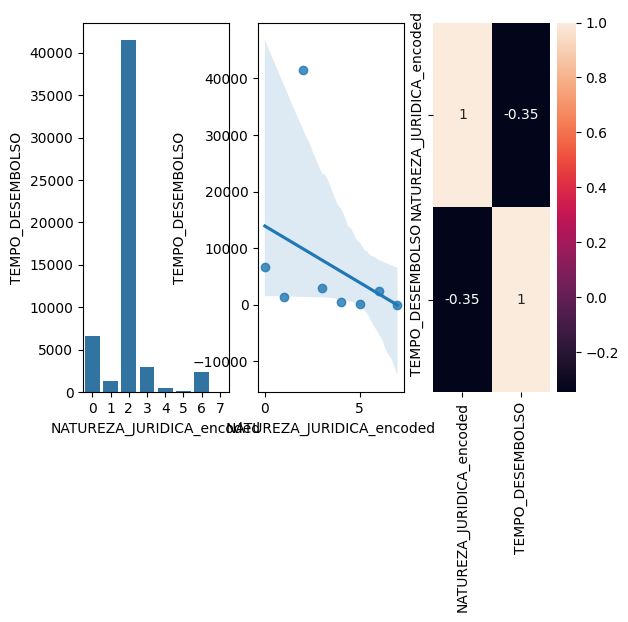

In [63]:
aux1 = fsa_ml_padrao[['NATUREZA_JURIDICA_encoded', 'TEMPO_DESEMBOLSO']].groupby( 'NATUREZA_JURIDICA_encoded' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='NATUREZA_JURIDICA_encoded', y='TEMPO_DESEMBOLSO', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='NATUREZA_JURIDICA_encoded', y='TEMPO_DESEMBOLSO', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

#### IQR (Interquartile Range) - Adequado para dados com Distribuição Não Normal, Menos influenciado por valores extremos

In [ ]:
Q1 = np.percentile(fsa_z_score, 25)
Q3 = np.percentile(fsa_z_score, 75)
IQR = Q3 - Q1

# Calcular limites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = (fsa_z_score < lower_bound) | (fsa_z_score > upper_bound)

# Criar uma série pandas
fsa_iqr = pd.Series(fsa_z_score)

# Extrair os outliers
outliers_identificados = fsa_iqr[outliers]

print("Outliers identificados (IQR):")
print(outliers_identificados.count())

NameError: name 'fsa_z_score' is not defined

#### Teste de Shapiro-Wilk - Verifica a normalidade dos dados. Um valor p > 0.05 indica que os dados são normalmente distribuídos.

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(fsa_z_score)
print('Estatística do Teste Shapiro-Wilk:', stat)
print('Valor p:', p)
if p > 0.05:
    print('Os dados parecem seguir uma distribuição normal (não rejeitamos H0)')
else:
    print('Os dados não seguem uma distribuição normal (rejeitamos H0)')

NameError: name 'fsa_z_score' is not defined

---

In [ ]:
#Linear Regression for FSA dataset
def linear_regression_fsa(y):
    
    X = fsa_desembolso_numerical[['ANO_CHAMADA_PUBLICA']]

    lin_reg = lm.LinearRegression()
    lin_reg.fit(X, y)
    ypred = lin_reg.predict(X)
    print('Dependent Variable:', y.name)
    print('Coefficient', lin_reg.coef_)
    print('Intercept', lin_reg.intercept_)
    print('MSQERR', msqerr(y, ypred))
    print('R2', lin_reg.score(X,y))

    plt.figure()
    plt.scatter(X,y)
    plt.plot(X, ypred, color='red')
    plt.xlabel('Ano da Chamada Pública')
    plt.ylabel(y.name)

In [ ]:
#Linear Regression for Renúncia fiscal dataset - Classificação de Nivel
def linear_regression_renuncia_fiscal(y):

    X = renuncia_fiscal_numerical[['CLASSIFICACAO_NIVEL_PRODUTORA']]

    lin_reg = lm.LinearRegression()
    lin_reg.fit(X,y)
    ypred = lin_reg.predict(X)

    ypred = lin_reg.predict(X)
    print('Dependent Variable:', y.name)
    print('Coefficient', lin_reg.coef_)
    print('Intercept', lin_reg.intercept_)
    print('MSQERR', msqerr(y, ypred))
    print('R2', lin_reg.score(X,y))

    plt.figure()
    plt.scatter(X,y)
    plt.plot(X, ypred, color='red')
    plt.xlabel('Classificação de Nivel de produtora')
    plt.ylabel(y.name)

Dependent Variable: LEI_8313
Coefficient [-210.15035492]
Intercept 78339.34420287167
MSQERR 73271642436.16594
R2 1.255874313876859e-06


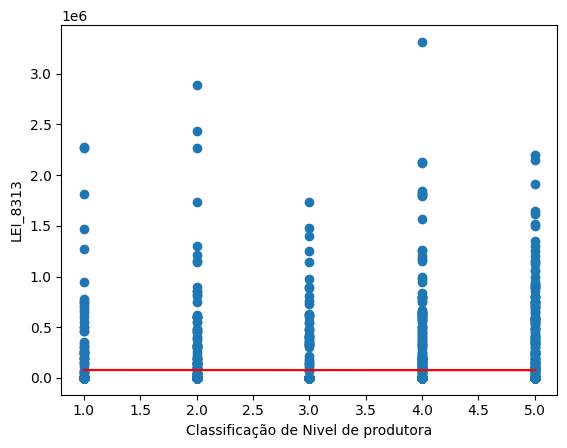

In [ ]:
linear_regression_renuncia_fiscal(renuncia_fiscal_numerical['LEI_8313'])

In [ ]:
#Linear Regression for Renúncia fiscal dataset - Total Captado
def linear_regression_renuncia_fiscal_2(y):

    X = renuncia_fiscal_numerical[['TOTAL_CAPTADO']]

    lin_reg = lm.LinearRegression()
    lin_reg.fit(X,y)
    ypred = lin_reg.predict(X)

    ypred = lin_reg.predict(X)
    print('Dependent Variable:', y.name)
    print('Coefficient', lin_reg.coef_)
    print('Intercept', lin_reg.intercept_)
    print('MSQERR', msqerr(y, ypred))
    print('R2', lin_reg.score(X,y))

    plt.figure()
    plt.scatter(X,y)
    plt.plot(X, ypred, color='red')
    plt.xlabel('TOTAL_CAPTADO')
    plt.ylabel(y.name)

Dependent Variable: CLASSIFICACAO_NIVEL_PRODUTORA
Coefficient [2.07933073e-07]
Intercept 3.2327775336198505
MSQERR 1.9629712025701478
R2 0.057911865242113225


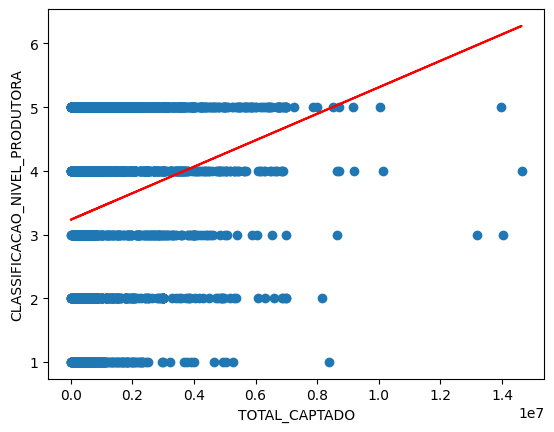

In [ ]:
linear_regression_renuncia_fiscal_2(renuncia_fiscal_numerical['CLASSIFICACAO_NIVEL_PRODUTORA'])

---

#### Hipóteses

##### Hipotese 1 = Empresas com Natureza Jurídica NÃO recebem o desembolso mais rápidos que empresas individuais não há diferenças significativas nos números

### Criação de Hipóteses

#### FSA - Desembolso

* Projetos no Sudeste tem maior probabilidade de serem aprovados
* Projetos captados via natureza jurídica LTDA tem prazo de liberação menor que outras naturezas jurídicas
* Projetos captados via natureza jurídica MEI tem maior chance de serem reprovados 
* O número de projetos aprovados em um estado é diretamente proporcional a quantidade de projetos inscritos, independentemente de localização

#### Renúncia Fiscal

* Projetos no Sudeste tem maior probabilidade de serem aprovados
* Projetos captados via natureza jurídica LTDA tem prazo de liberação menor que outras naturezas jurídicas
* Projetos captados via natureza jurídica MEI tem maior chance de serem reprovados 



Para determinar se uma hipótese é verdadeira ou refutar uma hipótese, você geralmente segue o processo de teste de hipóteses estatísticas. Aqui estão os passos gerais para conduzir um teste de hipóteses:

1. Formule as Hipóteses
Hipótese Nula (H0): A hipótese nula é uma declaração de que não há efeito ou diferença. É a hipótese que você tenta refutar.
Hipótese Alternativa (H1 ou Ha): A hipótese alternativa é uma declaração de que há um efeito ou diferença.
2. Escolha o Nível de Significância (α)
O nível de significância, α, é a probabilidade de rejeitar a hipótese nula quando ela é verdadeira. Comumente, α é escolhido como 0,05, mas pode ser 0,01, 0,10, ou outro valor dependendo do contexto.
3. Selecione o Teste Estatístico Apropriado
O teste estatístico escolhido depende da natureza dos seus dados e da hipótese que você está testando (por exemplo, teste t, teste z, ANOVA, teste qui-quadrado).
4. Calcule a Estatística de Teste e o Valor-p
A estatística de teste é um valor calculado a partir dos seus dados que você compara com um valor crítico para decidir se rejeita H0.
O valor-p é a probabilidade de observar um valor da estatística de teste tão extremo quanto, ou mais extremo do que, o valor observado, sob a hipótese nula.
5. Tome uma Decisão
Rejeitar H0: Se o valor-p for menor que o nível de significância α, você rejeita a hipótese nula em favor da hipótese alternativa.
Não Rejeitar H0: Se o valor-p for maior que o nível de significância α, você não rejeita a hipótese nula.

---